# Linear IVP adjoint example

This example calculates the optimal initial perturbation $\mathbf{u}(0)=\mathbf{u}_0$ which maximises $\mathbf{u}_T=\mathbf{u}(T)$. In other words we maximise $\mathcal{J}=\langle \mathbf{u}_T,\mathbf{W} \mathbf{u}_T\rangle/\langle \mathbf{u}_0,\mathbf{W} \mathbf{u}_0\rangle$, where $\mathbf{W}$ is a weight matrix, subject to $\mathbf{u}=(u,v,w)^T$ solving
\begin{eqnarray}
\frac{\partial u}{\partial t} + i\alpha u u_0 + u \frac{du_0}{dy} &=& i\alpha p + \frac{1}{\textit{Re}}\left(-\alpha^2u-\beta^2u + \frac{d^2u}{dy^2}\right),\\
\frac{\partial v}{\partial t} + i\alpha v u_0 &=& \frac{dp}{dy} + \frac{1}{\textit{Re}}\left(-\alpha^2v-\beta^2v + \frac{d^2v}{dy^2}\right),\\
\frac{\partial w}{\partial t} + i\alpha w u_0 &=& i\beta p + \frac{1}{\textit{Re}}\left(-\alpha^2w-\beta^2w + \frac{d^2w}{dy^2}\right),\\
i\alpha u + \frac{dv}{dy}+i\beta w &=& 0.
\end{eqnarray}
$\mathbf{W}$ is chosen so that $\langle \mathbf{u},\mathbf{W} \mathbf{u}\rangle\approx\int \bar{\mathbf{u}}\cdot  \mathbf{u}\;\textrm{d}y$.

The notebook is setup to calculate the stable line in figure 4.3 a) of 'Stability and transition in shear flows', Schmid and Henningson. 

In [145]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from dedalus.tools import jacobi
from dedalus.core import operators
from scipy import optimize

logger = logging.getLogger(__name__)

Set up the IVP that will find $\mathbf{u}_T$ from $\mathbf{u}_0$

In [146]:
# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

u0 = dist.Field(name='u0', bases=(ybasis))
v0 = dist.Field(name='v0', bases=(ybasis))
w0 = dist.Field(name='w0', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = 1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 5000

# # Problem
problem = d3.IVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("dt(u) + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = 0")
problem.add_equation("dt(v) + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = 0")
problem.add_equation("dt(w) + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = 0")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

{'LHS': interp(<Field 5106988080>, y=2),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'M': 0,
 'L': interp(<Field 5106988080>, y=2),
 'F': <Field 5106345312>,
 'domain': <dedalus.core.domain.Domain at 0x1306a4640>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

## Test
First we test forward and adjoint solves using the fact that $\langle \mathbf{u}_T^\dagger,\mathbf{u}_T\rangle=\langle \mathbf{u}_0^\dagger,\mathbf{u}_0\rangle$.

In [147]:
a0 = np.random.rand(Ny)+1j*np.random.rand(Ny)
a1 = np.random.rand(Ny)+1j*np.random.rand(Ny)
a2 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b0 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b1 = np.random.rand(Ny)+1j*np.random.rand(Ny)
b2 = np.random.rand(Ny)+1j*np.random.rand(Ny)

In [148]:
u['c'] = a0
v['c'] = a1
w['c'] = a2
solver = problem.build_solver(d3.RK443)

for (i,state) in enumerate(solver.state):
    if(i>2):
        print(state)
        state['g'] = 0

solver.stop_iteration = 100
timestep = 0.1
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
Ga0 = u['c']
Ga1 = v['c']
Ga2 = w['c']

2023-11-16 13:02:05,486 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+00/s
p
tau_u_1
tau_u_2
tau_v_1
tau_v_2
tau_w_1
tau_w_2
2023-11-16 13:02:05,490 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:02:05,588 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:02:05,589 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:02:05,589 solvers 0/1 INFO :: Final sim time: 9.99999999999998
2023-11-16 13:02:05,591 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1472 sec
2023-11-16 13:02:05,592 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01415 sec
2023-11-16 13:02:05,593 solvers 0/1 INFO :: Run time (iter 10-end): 0.08385 sec
2023-11-16 13:02:05,594 solvers 0/1 INFO :: CPU time (iter 10-end): 2.329e-05 cpu-hr
2023-11-16 13:02:05,594 solvers 0/1 INFO :: Speed: 2.224e+06 mode-stages/cpu-sec


In [96]:
solver.state_adj[0]['c'] = b0
solver.state_adj[1]['c'] = b1
solver.state_adj[2]['c'] = b2

for (i,state) in enumerate(solver.state_adj):
    if(i>2):
        print(state)
        state['g'] = 0

try:
    logger.info('Starting adjoint loop')
    while solver.iteration>0:
        solver.step_adjoint()
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
    
GTb0 = solver.state_adj[0]['c']
GTb1 = solver.state_adj[1]['c']
GTb2 = solver.state_adj[2]['c']

p_adj
tau_u_1_adj
tau_u_2_adj
tau_v_1_adj
tau_v_2_adj
tau_w_1_adj
tau_w_2_adj
2023-11-15 17:02:06,935 __main__ 0/1 INFO :: Starting adjoint loop
2023-11-15 17:02:06,936 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-11-15 17:02:07,241 solvers 0/1 INFO :: Final iteration: 0
2023-11-15 17:02:07,242 solvers 0/1 INFO :: Final sim time: -6.38378239159465e-16
2023-11-15 17:02:07,242 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1409 sec
2023-11-15 17:02:07,243 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


In [97]:
term1 = np.vdot(b0,Ga0) +  np.vdot(b1,Ga1) +  np.vdot(b2,Ga2)
term2 = np.vdot(GTb0,a0) + np.vdot(GTb1,a1) + np.vdot(GTb2,a2)

In [98]:
print(term1,term2)

(-0.4323263298057485+1.2398957098022083j) (-0.4323263298056938+1.2398957098022763j)


In [99]:
print('Rel. error = ', np.abs(term1-term2)/np.abs(term1))

Rel. error =  6.641838292946088e-14


Now we create the weight matrix

In [100]:
# Get spectrally accurate weight matrices
a_, b_ = ybasis.a, ybasis.b
integ_vector = jacobi.integration_vector(Ny, a_, b_)

W_field = dist.Field(name='W_field', bases=(ybasis), adjoint=True)
for i in range(Ny):
    W_field['c'][i] = integ_vector[i]
    
# Check integration
u.fill_random()
b = (np.conj(u)*u).evaluate()['c']
bg = (np.conj(u)*u).evaluate()['g']
print(d3.integ(np.conj(u)*u).evaluate()['g'][0])
print(np.sum(W_field['c']*b))

print(np.sum(W_field['g']*bg))

(157.46610096249725+0j)
(157.46610096249725+0j)
(157.46610096249725+0j)


Now we create the direct adjoint loop which calculates $\mathcal{J}$ and its gradient

In [183]:
def directAdjointLoop(velocity,Niter):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Rebuild the solver
    solver = problem.build_solver(d3.RK443)
    
    # Set initial condition (must zero all non-velocity terms)
    for (i,state) in enumerate(solver.state):
        if(i>2):
            state['g'] = 0
            
    u['g'] = velocity[:Ny]+1j*velocity[Ny:2*Ny]
    v['g'] = velocity[2*Ny:3*Ny]+1j*velocity[3*Ny:4*Ny]
    w['g'] = velocity[4*Ny:5*Ny]+1j*velocity[5*Ny:6*Ny]
    
    u0['g'] = u['g']
    v0['g'] = v['g']
    w0['g'] = w['g']
    
    solver.stop_iteration = Niter
    timestep = 0.5
    
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    
    u0Norm = np.vdot(u0['g'],W_field['g']*u0['g']) + np.vdot(v0['g'],W_field['g']*v0['g']) + np.vdot(w0['g'],W_field['g']*w0['g'])
    cost = np.vdot(u['g'],W_field['g']*u['g']) + np.vdot(v['g'],W_field['g']*v['g']) + np.vdot(w['g'],W_field['g']*w['g'])
    
    cost /= u0Norm
    
    # Set the adjoint final time condition
    solver.state_adj[0]['g'] = W_field['g']*u['g']/u0Norm
    solver.state_adj[1]['g'] = W_field['g']*v['g']/u0Norm
    solver.state_adj[2]['g'] = W_field['g']*w['g']/u0Norm

    for (i,state) in enumerate(solver.state_adj):
        if(i>2):
            state['g'] = 0
        
    try:
        logger.info('Starting adjoint loop')
        while solver.iteration>0:
            solver.step_adjoint()
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    
    gradu = -cost/u0Norm*W_field['g']*u0['g'] + solver.state_adj[0]['g']
    gradv = -cost/u0Norm*W_field['g']*v0['g'] + solver.state_adj[1]['g']
    gradw = -cost/u0Norm*W_field['g']*w0['g'] + solver.state_adj[2]['g']

    graduDat = np.hstack((gradu.real,gradu.imag))
    gradvDat = np.hstack((gradv.real,gradv.imag))
    gradwDat = np.hstack((gradw.real,gradw.imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -2*grad

In [202]:
velocity = np.random.rand(Ny*2*3)
opts = {'disp':False}
sol = optimize.minimize(lambda A: directAdjointLoop(A,100),velocity,method='L-BFGS-B',jac=True,options=opts)
print(np.sqrt(-sol.fun))

2023-11-16 14:32:47,964 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-11-16 14:32:47,968 __main__ 0/1 INFO :: Starting main loop
2023-11-16 14:32:48,070 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 14:32:48,071 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 14:32:48,074 solvers 0/1 INFO :: Final sim time: 2760.0
2023-11-16 14:32:48,086 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04715 sec
2023-11-16 14:32:48,088 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01317 sec
2023-11-16 14:32:48,090 solvers 0/1 INFO :: Run time (iter 10-end): 0.08949 sec
2023-11-16 14:32:48,091 solvers 0/1 INFO :: CPU time (iter 10-end): 2.486e-05 cpu-hr
2023-11-16 14:32:48,091 solvers 0/1 INFO :: Speed: 2.084e+06 mode-stages/cpu-sec
2023-11-16 14:32:48,094 __main__ 0/1 INFO :: Starting adjoint loop
2023-11-16 14:32:48,095 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-11-16 14:32:48,422 so

2023-11-16 14:32:51,293 solvers 0/1 INFO :: Run time (iter 10-end): 0.07628 sec
2023-11-16 14:32:51,294 solvers 0/1 INFO :: CPU time (iter 10-end): 2.119e-05 cpu-hr
2023-11-16 14:32:51,294 solvers 0/1 INFO :: Speed: 2.445e+06 mode-stages/cpu-sec
2023-11-16 14:32:51,296 __main__ 0/1 INFO :: Starting adjoint loop
2023-11-16 14:32:51,297 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-11-16 14:32:51,640 solvers 0/1 INFO :: Final iteration: 0
2023-11-16 14:32:51,641 solvers 0/1 INFO :: Final sim time: 2710.0
2023-11-16 14:32:51,642 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0544 sec
2023-11-16 14:32:51,643 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-11-16 14:32:51,727 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s
2023-11-16 14:32:51,732 __main__ 0/1 INFO :: Starting main loop
2023-11-16 14:32:51,891 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 14

2023-11-16 14:32:54,557 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04909 sec
2023-11-16 14:32:54,557 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-11-16 14:32:54,604 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-11-16 14:32:54,607 __main__ 0/1 INFO :: Starting main loop
2023-11-16 14:32:54,696 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 14:32:54,696 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 14:32:54,697 solvers 0/1 INFO :: Final sim time: 2760.0
2023-11-16 14:32:54,698 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04736 sec
2023-11-16 14:32:54,698 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01402 sec
2023-11-16 14:32:54,699 solvers 0/1 INFO :: Run time (iter 10-end): 0.07476 sec
2023-11-16 14:32:54,700 solvers 0/1 INFO :: CPU time (iter 10-end): 2.077e-05 cpu-hr
2023-11-16 14:32:54,700 solvers 0/1 INFO :: Speed: 2.494e+06 mode-stages/cpu-sec
2023-11-16 1

2023-11-16 14:32:57,605 solvers 0/1 INFO :: Final sim time: 2760.0
2023-11-16 14:32:57,605 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04945 sec
2023-11-16 14:32:57,606 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01876 sec
2023-11-16 14:32:57,607 solvers 0/1 INFO :: Run time (iter 10-end): 0.07321 sec
2023-11-16 14:32:57,607 solvers 0/1 INFO :: CPU time (iter 10-end): 2.034e-05 cpu-hr
2023-11-16 14:32:57,608 solvers 0/1 INFO :: Speed: 2.547e+06 mode-stages/cpu-sec
2023-11-16 14:32:57,609 __main__ 0/1 INFO :: Starting adjoint loop
2023-11-16 14:32:57,610 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-11-16 14:32:57,980 solvers 0/1 INFO :: Final iteration: 0
2023-11-16 14:32:57,982 solvers 0/1 INFO :: Final sim time: 2710.0
2023-11-16 14:32:57,983 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04945 sec
2023-11-16 14:32:57,983 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-11-16 14:32:58,053 subsystems 0/1 INFO 

In [11]:
%%time
# Loop over final times
opts = {'disp': True}
velocity = np.random.rand(Ny*2*3)

times = np.linspace(0,100,41)
times = times[3:]
gains = []
for ts in times:
    niter = int(ts/0.5)
    sol = optimize.minimize(lambda A: directAdjointLoop(A,niter),velocity,method='L-BFGS-B',jac=True,options=opts)
    gains.append(sol.fun)

2023-05-10 09:37:50,598 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:37:50,600 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:50,623 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:50,624 solvers 0/1 INFO :: Final iteration: 15
2023-05-10 09:37:50,625 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-10 09:37:50,625 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04699 sec
2023-05-10 09:37:50,626 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01828 sec
2023-05-10 09:37:50,626 solvers 0/1 INFO :: Run time (iter 10-end): 0.005051 sec
2023-05-10 09:37:50,627 solvers 0/1 INFO :: CPU time (iter 10-end): 1.403e-06 cpu-hr
2023-05-10 09:37:50,627 solvers 0/1 INFO :: Speed: 2.051e+06 mode-stages/cpu-sec
2023-05-10 09:37:50,628 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:50,629 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:3

 This problem is unconstrained.
/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


2023-05-10 09:37:50,939 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:37:50,941 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:50,967 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:50,968 solvers 0/1 INFO :: Final iteration: 15
2023-05-10 09:37:50,968 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-10 09:37:50,968 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04723 sec
2023-05-10 09:37:50,969 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0191 sec
2023-05-10 09:37:50,969 solvers 0/1 INFO :: Run time (iter 10-end): 0.006223 sec
2023-05-10 09:37:50,970 solvers 0/1 INFO :: CPU time (iter 10-end): 1.729e-06 cpu-hr
2023-05-10 09:37:50,971 solvers 0/1 INFO :: Speed: 1.665e+06 mode-stages/cpu-sec
2023-05-10 09:37:50,972 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:50,973 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37

2023-05-10 09:37:51,937 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:51,961 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:51,962 solvers 0/1 INFO :: Final iteration: 15
2023-05-10 09:37:51,963 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-10 09:37:51,963 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04675 sec
2023-05-10 09:37:51,963 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0176 sec
2023-05-10 09:37:51,964 solvers 0/1 INFO :: Run time (iter 10-end): 0.007128 sec
2023-05-10 09:37:51,964 solvers 0/1 INFO :: CPU time (iter 10-end): 1.98e-06 cpu-hr
2023-05-10 09:37:51,965 solvers 0/1 INFO :: Speed: 1.453e+06 mode-stages/cpu-sec
2023-05-10 09:37:51,965 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:51,966 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:52,052 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:52,053 solvers 0/1 INFO :: Final sim time: 8.881784197001252e-16
2023

2023-05-10 09:37:52,919 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:52,939 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:52,940 solvers 0/1 INFO :: Final iteration: 15
2023-05-10 09:37:52,941 solvers 0/1 INFO :: Final sim time: 7.500000000000001
2023-05-10 09:37:52,942 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04626 sec
2023-05-10 09:37:52,942 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0143 sec
2023-05-10 09:37:52,943 solvers 0/1 INFO :: Run time (iter 10-end): 0.006404 sec
2023-05-10 09:37:52,943 solvers 0/1 INFO :: CPU time (iter 10-end): 1.779e-06 cpu-hr
2023-05-10 09:37:52,944 solvers 0/1 INFO :: Speed: 1.618e+06 mode-stages/cpu-sec
2023-05-10 09:37:52,945 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:52,945 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:53,032 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:53,032 solvers 0/1 INFO :: Final sim time: 8.881784197001252e-16
202

2023-05-10 09:37:53,898 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:37:53,900 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:53,928 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:53,929 solvers 0/1 INFO :: Final iteration: 20
2023-05-10 09:37:53,929 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-10 09:37:53,930 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04613 sec
2023-05-10 09:37:53,930 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01731 sec
2023-05-10 09:37:53,931 solvers 0/1 INFO :: Run time (iter 10-end): 0.01069 sec
2023-05-10 09:37:53,932 solvers 0/1 INFO :: CPU time (iter 10-end): 2.969e-06 cpu-hr
2023-05-10 09:37:53,932 solvers 0/1 INFO :: Speed: 1.938e+06 mode-stages/cpu-sec
2023-05-10 09:37:53,933 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:53,934 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:54,045 solve

 This problem is unconstrained.


2023-05-10 09:37:54,309 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:54,310 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:37:54,310 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04932 sec
2023-05-10 09:37:54,311 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:37:54,353 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:37:54,355 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:54,380 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:54,381 solvers 0/1 INFO :: Final iteration: 20
2023-05-10 09:37:54,381 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-10 09:37:54,382 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04377 sec
2023-05-10 09:37:54,382 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01459 sec
2023-05-10 09:37:54,382 solvers 0/1 INFO :: Run time (iter 10-end): 0.0104 sec
2023-05-10 09:37:54,383 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:37:55,460 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:55,486 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:55,487 solvers 0/1 INFO :: Final iteration: 20
2023-05-10 09:37:55,487 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-10 09:37:55,488 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04854 sec
2023-05-10 09:37:55,488 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01612 sec
2023-05-10 09:37:55,489 solvers 0/1 INFO :: Run time (iter 10-end): 0.009605 sec
2023-05-10 09:37:55,490 solvers 0/1 INFO :: CPU time (iter 10-end): 2.668e-06 cpu-hr
2023-05-10 09:37:55,491 solvers 0/1 INFO :: Speed: 2.157e+06 mode-stages/cpu-sec
2023-05-10 09:37:55,492 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:55,492 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:55,599 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:55,600 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:37:55,600 solvers 0

2023-05-10 09:37:56,609 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01496 sec
2023-05-10 09:37:56,609 solvers 0/1 INFO :: Run time (iter 10-end): 0.0112 sec
2023-05-10 09:37:56,610 solvers 0/1 INFO :: CPU time (iter 10-end): 3.112e-06 cpu-hr
2023-05-10 09:37:56,610 solvers 0/1 INFO :: Speed: 1.849e+06 mode-stages/cpu-sec
2023-05-10 09:37:56,611 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:56,612 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:56,718 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:56,718 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:37:56,719 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04893 sec
2023-05-10 09:37:56,719 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    8    f= -1.81793D+01    |proj g|=  9.46081D-04
2023-05-10 09:37:56,763 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-

2023-05-10 09:37:57,730 solvers 0/1 INFO :: CPU time (iter 10-end): 3.017e-06 cpu-hr
2023-05-10 09:37:57,730 solvers 0/1 INFO :: Speed: 1.908e+06 mode-stages/cpu-sec
2023-05-10 09:37:57,731 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:57,732 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:57,835 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:57,836 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:37:57,837 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04487 sec
2023-05-10 09:37:57,837 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   14    f= -1.82071D+01    |proj g|=  3.87017D-05
2023-05-10 09:37:57,885 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:37:57,887 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:57,914 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:57,914 solvers 0

2023-05-10 09:37:58,844 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:37:58,845 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:37:58,951 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:37:58,952 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:37:58,952 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0488 sec
2023-05-10 09:37:58,953 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   20    f= -1.82072D+01    |proj g|=  1.45953D-05
2023-05-10 09:37:58,998 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:37:59,000 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:37:59,026 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:37:59,027 solvers 0/1 INFO :: Final iteration: 20
2023-05-10 09:37:59,027 solvers 0/1 INFO :: Final sim time: 10.0
2023-05-10 09:37:59,027 solvers 0/1 INFO :: Setup time (init - iter 0):

2023-05-10 09:37:59,996 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:37:59,996 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:37:59,997 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04691 sec
2023-05-10 09:37:59,997 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01636 sec
2023-05-10 09:37:59,998 solvers 0/1 INFO :: Run time (iter 10-end): 0.01458 sec
2023-05-10 09:37:59,998 solvers 0/1 INFO :: CPU time (iter 10-end): 4.051e-06 cpu-hr
2023-05-10 09:37:59,999 solvers 0/1 INFO :: Speed: 2.131e+06 mode-stages/cpu-sec
2023-05-10 09:38:00,000 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:00,001 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.


 This problem is unconstrained.


2023-05-10 09:38:00,128 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:00,129 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:00,130 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04691 sec
2023-05-10 09:38:00,130 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:00,175 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:00,177 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:00,208 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:00,209 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:00,209 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:38:00,210 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04638 sec
2023-05-10 09:38:00,210 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01627 sec
2023-05-10 09:38:00,211 solvers 0/1 INFO :: Run time (iter 10-end): 0.01463 sec
2023-05-10 09:38:00,211 solvers 0/1 INFO :: CPU time (

2023-05-10 09:38:01,449 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:01,478 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:01,479 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:01,481 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:38:01,481 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04484 sec
2023-05-10 09:38:01,482 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01408 sec
2023-05-10 09:38:01,483 solvers 0/1 INFO :: Run time (iter 10-end): 0.01554 sec
2023-05-10 09:38:01,484 solvers 0/1 INFO :: CPU time (iter 10-end): 4.315e-06 cpu-hr
2023-05-10 09:38:01,485 solvers 0/1 INFO :: Speed: 2.001e+06 mode-stages/cpu-sec
2023-05-10 09:38:01,486 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:01,487 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:01,613 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:01,613 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:01,614 solvers 0/

2023-05-10 09:38:02,734 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01739 sec
2023-05-10 09:38:02,734 solvers 0/1 INFO :: Run time (iter 10-end): 0.01428 sec
2023-05-10 09:38:02,734 solvers 0/1 INFO :: CPU time (iter 10-end): 3.966e-06 cpu-hr
2023-05-10 09:38:02,735 solvers 0/1 INFO :: Speed: 2.177e+06 mode-stages/cpu-sec
2023-05-10 09:38:02,736 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:02,737 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:02,861 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:02,862 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:02,862 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04856 sec
2023-05-10 09:38:02,863 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    6    f= -2.43868D+01    |proj g|=  8.91616D-03
2023-05-10 09:38:02,906 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023

2023-05-10 09:38:03,985 solvers 0/1 INFO :: Speed: 2.194e+06 mode-stages/cpu-sec
2023-05-10 09:38:03,986 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:03,987 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:04,106 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:04,107 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:04,108 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04478 sec
2023-05-10 09:38:04,108 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -2.52336D+01    |proj g|=  3.72001D-04
2023-05-10 09:38:04,154 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:04,156 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:04,186 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:04,186 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:04,187 solvers 0/1 INFO :: Final sim 

2023-05-10 09:38:05,319 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:05,320 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:05,321 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04574 sec
2023-05-10 09:38:05,321 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -2.52368D+01    |proj g|=  5.08197D-05
2023-05-10 09:38:05,367 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:05,369 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:05,398 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:05,399 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:05,399 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:38:05,400 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04538 sec
2023-05-10 09:38:05,400 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01437 sec
2023-05-10 09:38:05,401 solvers 0/1 INFO :: Run time (iter 10-end): 0.01


At iterate   22    f= -2.52369D+01    |proj g|=  2.36829D-05
2023-05-10 09:38:06,575 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:06,578 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:06,611 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:06,612 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:06,612 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:38:06,613 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04888 sec
2023-05-10 09:38:06,613 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01728 sec
2023-05-10 09:38:06,614 solvers 0/1 INFO :: Run time (iter 10-end): 0.01651 sec
2023-05-10 09:38:06,614 solvers 0/1 INFO :: CPU time (iter 10-end): 4.585e-06 cpu-hr
2023-05-10 09:38:06,615 solvers 0/1 INFO :: Speed: 1.883e+06 mode-stages/cpu-sec
2023-05-10 09:38:06,616 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:06,616 solvers 0/1 INFO :: Warning: Only works if 

2023-05-10 09:38:07,826 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:07,827 solvers 0/1 INFO :: Final iteration: 25
2023-05-10 09:38:07,827 solvers 0/1 INFO :: Final sim time: 12.5
2023-05-10 09:38:07,827 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05428 sec
2023-05-10 09:38:07,828 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01384 sec
2023-05-10 09:38:07,828 solvers 0/1 INFO :: Run time (iter 10-end): 0.01508 sec
2023-05-10 09:38:07,829 solvers 0/1 INFO :: CPU time (iter 10-end): 4.188e-06 cpu-hr
2023-05-10 09:38:07,829 solvers 0/1 INFO :: Speed: 2.061e+06 mode-stages/cpu-sec
2023-05-10 09:38:07,830 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:07,831 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:07,947 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:07,948 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:07,949 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05428 sec
2023-05-10 09:

 This problem is unconstrained.


2023-05-10 09:38:08,804 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:08,805 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:08,806 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04799 sec
2023-05-10 09:38:08,807 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:08,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:08,853 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:08,887 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:08,888 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:08,888 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:08,889 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04601 sec
2023-05-10 09:38:08,889 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0152 sec
2023-05-10 09:38:08,890 solvers 0/1 INFO :: Run time (iter 10-end): 0.01872 sec
2023-05-10 09:38:08,891 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:38:10,201 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:10,238 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:10,238 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:10,239 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:10,239 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04563 sec
2023-05-10 09:38:10,240 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01606 sec
2023-05-10 09:38:10,241 solvers 0/1 INFO :: Run time (iter 10-end): 0.02112 sec
2023-05-10 09:38:10,241 solvers 0/1 INFO :: CPU time (iter 10-end): 5.867e-06 cpu-hr
2023-05-10 09:38:10,242 solvers 0/1 INFO :: Speed: 1.962e+06 mode-stages/cpu-sec
2023-05-10 09:38:10,243 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:10,243 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:10,378 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:10,379 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:10,379 solvers 0/

2023-05-10 09:38:11,592 solvers 0/1 INFO :: Run time (iter 10-end): 0.01903 sec
2023-05-10 09:38:11,593 solvers 0/1 INFO :: CPU time (iter 10-end): 5.285e-06 cpu-hr
2023-05-10 09:38:11,593 solvers 0/1 INFO :: Speed: 2.178e+06 mode-stages/cpu-sec
2023-05-10 09:38:11,594 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:11,595 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:11,727 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:11,728 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:11,729 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04543 sec
2023-05-10 09:38:11,729 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    5    f= -2.74111D+01    |proj g|=  1.31494D-02
2023-05-10 09:38:11,778 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-10 09:38:11,780 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:11,8

2023-05-10 09:38:12,948 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:12,948 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:13,088 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:13,088 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:13,089 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04782 sec
2023-05-10 09:38:13,090 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -3.05296D+01    |proj g|=  8.42623D-04
2023-05-10 09:38:13,137 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:13,139 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:13,172 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:13,173 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:13,173 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:13,174 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-10 09:38:14,441 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:14,442 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04779 sec
2023-05-10 09:38:14,443 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   15    f= -3.05407D+01    |proj g|=  8.50944D-05
2023-05-10 09:38:14,488 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:14,490 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:14,525 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:14,526 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:14,527 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:14,527 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04558 sec
2023-05-10 09:38:14,528 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01654 sec
2023-05-10 09:38:14,528 solvers 0/1 INFO :: Run time (iter 10-end): 0.01896 sec
2023-05-10 09:38:14,528 solvers 0/1 INFO :: CPU time (i


At iterate   21    f= -3.05410D+01    |proj g|=  2.32748D-05
2023-05-10 09:38:15,845 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:15,846 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:15,881 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:15,881 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:15,882 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:15,882 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04702 sec
2023-05-10 09:38:15,883 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0172 sec
2023-05-10 09:38:15,883 solvers 0/1 INFO :: Run time (iter 10-end): 0.01707 sec
2023-05-10 09:38:15,883 solvers 0/1 INFO :: CPU time (iter 10-end): 4.741e-06 cpu-hr
2023-05-10 09:38:15,884 solvers 0/1 INFO :: Speed: 2.428e+06 mode-stages/cpu-sec
2023-05-10 09:38:15,885 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:15,885 solvers 0/1 INFO :: Warning: Only works if F

2023-05-10 09:38:17,239 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:17,274 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:17,275 solvers 0/1 INFO :: Final iteration: 30
2023-05-10 09:38:17,275 solvers 0/1 INFO :: Final sim time: 15.0
2023-05-10 09:38:17,276 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04752 sec
2023-05-10 09:38:17,276 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0155 sec
2023-05-10 09:38:17,276 solvers 0/1 INFO :: Run time (iter 10-end): 0.01958 sec
2023-05-10 09:38:17,277 solvers 0/1 INFO :: CPU time (iter 10-end): 5.44e-06 cpu-hr
2023-05-10 09:38:17,277 solvers 0/1 INFO :: Speed: 2.116e+06 mode-stages/cpu-sec
2023-05-10 09:38:17,278 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:17,279 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:17,421 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:17,422 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:17,422 solvers 0/1 

 This problem is unconstrained.


2023-05-10 09:38:17,947 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:17,947 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:17,948 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04567 sec
2023-05-10 09:38:17,949 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:17,994 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:17,996 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:18,033 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:18,034 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:18,034 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:18,035 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04637 sec
2023-05-10 09:38:18,035 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01543 sec
2023-05-10 09:38:18,035 solvers 0/1 INFO :: Run time (iter 10-end): 0.0216 sec
2023-05-10 09:38:18,036 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:38:19,589 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:19,626 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:19,627 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:19,628 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:19,628 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04682 sec
2023-05-10 09:38:19,629 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01506 sec
2023-05-10 09:38:19,629 solvers 0/1 INFO :: Run time (iter 10-end): 0.02277 sec
2023-05-10 09:38:19,630 solvers 0/1 INFO :: CPU time (iter 10-end): 6.326e-06 cpu-hr
2023-05-10 09:38:19,630 solvers 0/1 INFO :: Speed: 2.275e+06 mode-stages/cpu-sec
2023-05-10 09:38:19,631 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:19,631 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:19,786 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:19,787 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:19,788 solvers 0/

2023-05-10 09:38:21,228 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01723 sec
2023-05-10 09:38:21,228 solvers 0/1 INFO :: Run time (iter 10-end): 0.02487 sec
2023-05-10 09:38:21,228 solvers 0/1 INFO :: CPU time (iter 10-end): 6.908e-06 cpu-hr
2023-05-10 09:38:21,229 solvers 0/1 INFO :: Speed: 2.083e+06 mode-stages/cpu-sec
2023-05-10 09:38:21,230 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:21,230 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:21,402 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:21,403 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:21,403 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04782 sec
2023-05-10 09:38:21,404 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:21,452 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:21,454 __main__ 0/1 INFO :: Starting main loop
20

2023-05-10 09:38:22,863 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:22,864 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:23,035 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:23,036 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:23,036 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05584 sec
2023-05-10 09:38:23,037 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -3.27271D+01    |proj g|=  1.15342D-03
2023-05-10 09:38:23,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:23,090 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:23,136 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:23,137 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:23,137 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:23,138 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-10 09:38:24,651 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:24,651 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04716 sec
2023-05-10 09:38:24,652 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   15    f= -3.27474D+01    |proj g|=  1.29806D-04
2023-05-10 09:38:24,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:24,700 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:24,737 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:24,738 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:24,739 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:24,739 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04701 sec
2023-05-10 09:38:24,739 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01541 sec
2023-05-10 09:38:24,740 solvers 0/1 INFO :: Run time (iter 10-end): 0.02201 sec
2023-05-10 09:38:24,740 solvers 0/1 INFO :: CPU time (i


At iterate   21    f= -3.27478D+01    |proj g|=  3.06817D-05
2023-05-10 09:38:26,217 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:26,219 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:26,258 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:26,259 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:26,259 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:26,260 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04739 sec
2023-05-10 09:38:26,260 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01495 sec
2023-05-10 09:38:26,261 solvers 0/1 INFO :: Run time (iter 10-end): 0.02391 sec
2023-05-10 09:38:26,261 solvers 0/1 INFO :: CPU time (iter 10-end): 6.642e-06 cpu-hr
2023-05-10 09:38:26,262 solvers 0/1 INFO :: Speed: 2.166e+06 mode-stages/cpu-sec
2023-05-10 09:38:26,263 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:26,263 solvers 0/1 INFO :: Warning: Only works if 

2023-05-10 09:38:27,815 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:27,815 solvers 0/1 INFO :: Final iteration: 35
2023-05-10 09:38:27,816 solvers 0/1 INFO :: Final sim time: 17.5
2023-05-10 09:38:27,816 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05396 sec
2023-05-10 09:38:27,817 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01406 sec
2023-05-10 09:38:27,817 solvers 0/1 INFO :: Run time (iter 10-end): 0.02328 sec
2023-05-10 09:38:27,817 solvers 0/1 INFO :: CPU time (iter 10-end): 6.466e-06 cpu-hr
2023-05-10 09:38:27,818 solvers 0/1 INFO :: Speed: 2.225e+06 mode-stages/cpu-sec
2023-05-10 09:38:27,819 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:27,820 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:27,971 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:27,972 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:27,972 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05396 sec
2023-05-10 09:

2023-05-10 09:38:29,272 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:29,274 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:29,319 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:29,319 solvers 0/1 INFO :: Final iteration: 40
2023-05-10 09:38:29,320 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-10 09:38:29,320 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0461 sec
2023-05-10 09:38:29,321 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01675 sec
2023-05-10 09:38:29,321 solvers 0/1 INFO :: Run time (iter 10-end): 0.02755 sec
2023-05-10 09:38:29,322 solvers 0/1 INFO :: CPU time (iter 10-end): 7.654e-06 cpu-hr
2023-05-10 09:38:29,322 solvers 0/1 INFO :: Speed: 2.256e+06 mode-stages/cpu-sec
2023-05-10 09:38:29,323 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:29,324 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:29,496 solver

 This problem is unconstrained.


2023-05-10 09:38:29,778 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:29,779 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:29,780 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05042 sec
2023-05-10 09:38:29,781 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:29,826 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:29,828 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:29,869 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:29,869 solvers 0/1 INFO :: Final iteration: 40
2023-05-10 09:38:29,870 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-10 09:38:29,871 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0462 sec
2023-05-10 09:38:29,871 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01536 sec
2023-05-10 09:38:29,871 solvers 0/1 INFO :: Run time (iter 10-end): 0.02546 sec
2023-05-10 09:38:29,872 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:38:31,454 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:31,495 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:31,496 solvers 0/1 INFO :: Final iteration: 40
2023-05-10 09:38:31,496 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-10 09:38:31,497 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04962 sec
2023-05-10 09:38:31,497 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01487 sec
2023-05-10 09:38:31,498 solvers 0/1 INFO :: Run time (iter 10-end): 0.02669 sec
2023-05-10 09:38:31,499 solvers 0/1 INFO :: CPU time (iter 10-end): 7.414e-06 cpu-hr
2023-05-10 09:38:31,499 solvers 0/1 INFO :: Speed: 2.329e+06 mode-stages/cpu-sec
2023-05-10 09:38:31,500 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:31,500 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:31,674 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:31,675 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:31,675 solvers 0/

2023-05-10 09:38:33,113 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01482 sec
2023-05-10 09:38:33,113 solvers 0/1 INFO :: Run time (iter 10-end): 0.02766 sec
2023-05-10 09:38:33,114 solvers 0/1 INFO :: CPU time (iter 10-end): 7.683e-06 cpu-hr
2023-05-10 09:38:33,114 solvers 0/1 INFO :: Speed: 2.247e+06 mode-stages/cpu-sec
2023-05-10 09:38:33,115 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:33,116 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:33,291 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:33,292 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:33,292 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04659 sec
2023-05-10 09:38:33,293 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    7    f= -2.87181D+01    |proj g|=  1.45757D-02
2023-05-10 09:38:33,341 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023

2023-05-10 09:38:34,752 solvers 0/1 INFO :: CPU time (iter 10-end): 8.016e-06 cpu-hr
2023-05-10 09:38:34,753 solvers 0/1 INFO :: Speed: 2.154e+06 mode-stages/cpu-sec
2023-05-10 09:38:34,754 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:34,754 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:34,930 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:34,931 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:34,931 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04867 sec
2023-05-10 09:38:34,932 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   13    f= -3.16576D+01    |proj g|=  2.06264D-04
2023-05-10 09:38:34,982 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-10 09:38:34,984 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:35,026 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:35,026 solvers 0

2023-05-10 09:38:36,394 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:36,394 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:36,574 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:36,575 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:36,576 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04678 sec
2023-05-10 09:38:36,576 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   19    f= -3.16590D+01    |proj g|=  3.35217D-05
2023-05-10 09:38:36,624 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:36,626 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:36,667 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:36,667 solvers 0/1 INFO :: Final iteration: 40
2023-05-10 09:38:36,668 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-10 09:38:36,668 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-10 09:38:38,208 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:38,209 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:38,209 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04859 sec
2023-05-10 09:38:38,210 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   25    f= -3.16591D+01    |proj g|=  1.41617D-05
2023-05-10 09:38:38,257 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:38,259 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:38,300 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:38,301 solvers 0/1 INFO :: Final iteration: 40
2023-05-10 09:38:38,301 solvers 0/1 INFO :: Final sim time: 20.0
2023-05-10 09:38:38,302 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04814 sec
2023-05-10 09:38:38,302 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01507 sec
2023-05-10 09:38:38,303 solvers 0/1 INFO :: Run time (iter 10-end): 0.02


At iterate   30    f= -3.16591D+01    |proj g|=  8.77367D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     30     39      1     0     0   8.774D-06  -3.166D+01
  F =  -31.659069313937866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-10 09:38:39,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:39,895 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:39,942 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:39,943 solvers 0/1 INFO :: Final iteration: 45
2023-05-10 09:38:39,943 solvers 0

 This problem is unconstrained.


2023-05-10 09:38:40,438 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:40,439 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:40,439 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04493 sec
2023-05-10 09:38:40,440 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:40,483 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:40,485 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:40,530 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:40,531 solvers 0/1 INFO :: Final iteration: 45
2023-05-10 09:38:40,531 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-10 09:38:40,532 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04399 sec
2023-05-10 09:38:40,532 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01464 sec
2023-05-10 09:38:40,532 solvers 0/1 INFO :: Run time (iter 10-end): 0.03055 sec
2023-05-10 09:38:40,533 solvers 0/1 INFO :: CPU time (

2023-05-10 09:38:42,252 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:42,297 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:42,298 solvers 0/1 INFO :: Final iteration: 45
2023-05-10 09:38:42,298 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-10 09:38:42,298 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04754 sec
2023-05-10 09:38:42,299 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01428 sec
2023-05-10 09:38:42,299 solvers 0/1 INFO :: Run time (iter 10-end): 0.03085 sec
2023-05-10 09:38:42,300 solvers 0/1 INFO :: CPU time (iter 10-end): 8.569e-06 cpu-hr
2023-05-10 09:38:42,300 solvers 0/1 INFO :: Speed: 2.351e+06 mode-stages/cpu-sec
2023-05-10 09:38:42,301 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:42,302 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:42,492 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:42,493 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:42,494 solvers 0/

2023-05-10 09:38:44,064 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04544 sec
2023-05-10 09:38:44,064 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01548 sec
2023-05-10 09:38:44,065 solvers 0/1 INFO :: Run time (iter 10-end): 0.03219 sec
2023-05-10 09:38:44,065 solvers 0/1 INFO :: CPU time (iter 10-end): 8.942e-06 cpu-hr
2023-05-10 09:38:44,066 solvers 0/1 INFO :: Speed: 2.253e+06 mode-stages/cpu-sec
2023-05-10 09:38:44,067 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:44,068 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:44,273 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:44,273 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:44,274 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04544 sec
2023-05-10 09:38:44,275 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    9    f= -2.82995D+01    |proj g|=  1.22652D-03
2023-05-10 09:38:44,319 subsystems 0/1 INFO :: Build

2023-05-10 09:38:45,835 solvers 0/1 INFO :: Run time (iter 10-end): 0.03049 sec
2023-05-10 09:38:45,836 solvers 0/1 INFO :: CPU time (iter 10-end): 8.469e-06 cpu-hr
2023-05-10 09:38:45,837 solvers 0/1 INFO :: Speed: 2.379e+06 mode-stages/cpu-sec
2023-05-10 09:38:45,837 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:45,838 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:46,028 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:46,029 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:46,030 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0475 sec
2023-05-10 09:38:46,031 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   15    f= -2.83203D+01    |proj g|=  6.99492D-05
2023-05-10 09:38:46,078 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:46,080 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:46,12

2023-05-10 09:38:47,621 solvers 0/1 INFO :: Speed: 2.297e+06 mode-stages/cpu-sec
2023-05-10 09:38:47,622 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:47,623 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:47,807 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:47,808 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:47,808 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04951 sec
2023-05-10 09:38:47,809 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   21    f= -2.83204D+01    |proj g|=  3.03034D-05
2023-05-10 09:38:47,856 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:38:47,858 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:47,903 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:47,904 solvers 0/1 INFO :: Final iteration: 45
2023-05-10 09:38:47,905 solvers 0/1 INFO :: Final sim 

2023-05-10 09:38:49,568 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:49,569 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:49,570 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04493 sec
2023-05-10 09:38:49,570 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   27    f= -2.83204D+01    |proj g|=  1.12819D-05
2023-05-10 09:38:49,614 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:49,616 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:49,665 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:49,665 solvers 0/1 INFO :: Final iteration: 45
2023-05-10 09:38:49,666 solvers 0/1 INFO :: Final sim time: 22.5
2023-05-10 09:38:49,666 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04412 sec
2023-05-10 09:38:49,667 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01646 sec
2023-05-10 09:38:49,668 solvers 0/1 INFO :: Run time (iter 10-end): 0.03

 This problem is unconstrained.


2023-05-10 09:38:50,517 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:50,517 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:50,518 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04425 sec
2023-05-10 09:38:50,519 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:38:50,563 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:50,565 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:50,617 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:50,617 solvers 0/1 INFO :: Final iteration: 50
2023-05-10 09:38:50,618 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-10 09:38:50,619 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04531 sec
2023-05-10 09:38:50,619 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01741 sec
2023-05-10 09:38:50,620 solvers 0/1 INFO :: Run time (iter 10-end): 0.03393 sec
2023-05-10 09:38:50,621 solvers 0/1 INFO :: CPU time (

2023-05-10 09:38:52,490 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:52,541 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:52,541 solvers 0/1 INFO :: Final iteration: 50
2023-05-10 09:38:52,542 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-10 09:38:52,543 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04708 sec
2023-05-10 09:38:52,544 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01546 sec
2023-05-10 09:38:52,544 solvers 0/1 INFO :: Run time (iter 10-end): 0.03522 sec
2023-05-10 09:38:52,545 solvers 0/1 INFO :: CPU time (iter 10-end): 9.782e-06 cpu-hr
2023-05-10 09:38:52,546 solvers 0/1 INFO :: Speed: 2.353e+06 mode-stages/cpu-sec
2023-05-10 09:38:52,547 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:52,548 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:52,762 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:52,762 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:52,763 solvers 0/

2023-05-10 09:38:54,457 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04599 sec
2023-05-10 09:38:54,457 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0141 sec
2023-05-10 09:38:54,458 solvers 0/1 INFO :: Run time (iter 10-end): 0.03524 sec
2023-05-10 09:38:54,458 solvers 0/1 INFO :: CPU time (iter 10-end): 9.789e-06 cpu-hr
2023-05-10 09:38:54,459 solvers 0/1 INFO :: Speed: 2.352e+06 mode-stages/cpu-sec
2023-05-10 09:38:54,460 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:54,460 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:54,667 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:54,668 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:54,669 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04599 sec
2023-05-10 09:38:54,669 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -2.43878D+01    |proj g|=  2.48750D-04
2023-05-10 09:38:54,713 subsystems 0/1 INFO :: Buildi

2023-05-10 09:38:56,347 solvers 0/1 INFO :: Run time (iter 10-end): 0.03331 sec
2023-05-10 09:38:56,347 solvers 0/1 INFO :: CPU time (iter 10-end): 9.253e-06 cpu-hr
2023-05-10 09:38:56,348 solvers 0/1 INFO :: Speed: 2.488e+06 mode-stages/cpu-sec
2023-05-10 09:38:56,349 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:56,349 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:56,563 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:56,564 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:56,565 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04438 sec
2023-05-10 09:38:56,566 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -2.43898D+01    |proj g|=  3.14624D-05
2023-05-10 09:38:56,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:38:56,614 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:56,6

2023-05-10 09:38:58,256 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:38:58,257 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:38:58,472 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:38:58,473 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:38:58,473 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04656 sec
2023-05-10 09:38:58,474 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   21    f= -2.43898D+01    |proj g|=  1.64155D-05
2023-05-10 09:38:58,518 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:38:58,520 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:38:58,571 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:38:58,572 solvers 0/1 INFO :: Final iteration: 50
2023-05-10 09:38:58,572 solvers 0/1 INFO :: Final sim time: 25.0
2023-05-10 09:38:58,573 solvers 0/1 INFO :: Setup time (init - iter 0)

2023-05-10 09:39:00,383 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:00,384 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:00,384 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04726 sec
2023-05-10 09:39:00,385 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   27    f= -2.43899D+01    |proj g|=  6.63503D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  768     27     33      1     0     0   6.635D-06  -2.439D+01
  F =  -24.389856415991421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2023-05-10 09:39:00,436 subsystems 0/1 INFO :: Buildi

 This problem is unconstrained.


2023-05-10 09:39:01,072 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:01,072 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:01,073 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0439 sec
2023-05-10 09:39:01,074 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:01,118 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:39:01,119 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:01,174 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:01,175 solvers 0/1 INFO :: Final iteration: 55
2023-05-10 09:39:01,176 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-10 09:39:01,176 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04433 sec
2023-05-10 09:39:01,177 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01399 sec
2023-05-10 09:39:01,177 solvers 0/1 INFO :: Run time (iter 10-end): 0.041 sec
2023-05-10 09:39:01,178 solvers 0/1 INFO :: CPU time (ite

2023-05-10 09:39:03,150 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:03,203 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:03,204 solvers 0/1 INFO :: Final iteration: 55
2023-05-10 09:39:03,204 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-10 09:39:03,205 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04428 sec
2023-05-10 09:39:03,205 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01412 sec
2023-05-10 09:39:03,206 solvers 0/1 INFO :: Run time (iter 10-end): 0.03907 sec
2023-05-10 09:39:03,207 solvers 0/1 INFO :: CPU time (iter 10-end): 1.085e-05 cpu-hr
2023-05-10 09:39:03,208 solvers 0/1 INFO :: Speed: 2.387e+06 mode-stages/cpu-sec
2023-05-10 09:39:03,208 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:03,209 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:03,482 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:03,483 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:03,483 solvers 0/

2023-05-10 09:39:05,299 solvers 0/1 INFO :: Final sim time: 27.5
2023-05-10 09:39:05,299 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04587 sec
2023-05-10 09:39:05,300 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01404 sec
2023-05-10 09:39:05,301 solvers 0/1 INFO :: Run time (iter 10-end): 0.0416 sec
2023-05-10 09:39:05,302 solvers 0/1 INFO :: CPU time (iter 10-end): 1.156e-05 cpu-hr
2023-05-10 09:39:05,302 solvers 0/1 INFO :: Speed: 2.241e+06 mode-stages/cpu-sec
2023-05-10 09:39:05,303 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:05,305 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:05,538 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:05,538 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:05,539 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04587 sec
2023-05-10 09:39:05,540 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -2.12130D+01    |proj g|=  

2023-05-10 09:39:07,367 solvers 0/1 INFO :: Run time (iter 10-end): 0.03872 sec
2023-05-10 09:39:07,368 solvers 0/1 INFO :: CPU time (iter 10-end): 1.075e-05 cpu-hr
2023-05-10 09:39:07,368 solvers 0/1 INFO :: Speed: 2.408e+06 mode-stages/cpu-sec
2023-05-10 09:39:07,369 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:07,370 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:07,609 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:07,610 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:07,610 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04482 sec
2023-05-10 09:39:07,611 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -2.12139D+01    |proj g|=  2.02628D-05
2023-05-10 09:39:07,664 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-05-10 09:39:07,666 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:07,7

2023-05-10 09:39:09,469 solvers 0/1 INFO :: Speed: 2.229e+06 mode-stages/cpu-sec
2023-05-10 09:39:09,470 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:09,471 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:09,713 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:09,713 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:09,714 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04522 sec
2023-05-10 09:39:09,714 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   23    f= -2.12140D+01    |proj g|=  2.45792D-05
2023-05-10 09:39:09,759 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:39:09,761 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:09,819 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:09,819 solvers 0/1 INFO :: Final iteration: 55
2023-05-10 09:39:09,820 solvers 0/1 INFO :: Final sim 

 This problem is unconstrained.


2023-05-10 09:39:11,159 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:11,160 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:11,161 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05015 sec
2023-05-10 09:39:11,162 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:11,205 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:39:11,207 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:11,264 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:11,265 solvers 0/1 INFO :: Final iteration: 60
2023-05-10 09:39:11,265 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-10 09:39:11,266 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04397 sec
2023-05-10 09:39:11,267 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01429 sec
2023-05-10 09:39:11,267 solvers 0/1 INFO :: Run time (iter 10-end): 0.04254 sec
2023-05-10 09:39:11,268 solvers 0/1 INFO :: CPU time (

2023-05-10 09:39:13,399 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:13,460 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:13,461 solvers 0/1 INFO :: Final iteration: 60
2023-05-10 09:39:13,461 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-10 09:39:13,462 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04569 sec
2023-05-10 09:39:13,462 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0156 sec
2023-05-10 09:39:13,463 solvers 0/1 INFO :: Run time (iter 10-end): 0.04528 sec
2023-05-10 09:39:13,463 solvers 0/1 INFO :: CPU time (iter 10-end): 1.258e-05 cpu-hr
2023-05-10 09:39:13,464 solvers 0/1 INFO :: Speed: 2.288e+06 mode-stages/cpu-sec
2023-05-10 09:39:13,465 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:13,465 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:13,716 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:13,717 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:13,717 solvers 0/1

2023-05-10 09:39:15,730 solvers 0/1 INFO :: Final sim time: 30.0
2023-05-10 09:39:15,730 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04958 sec
2023-05-10 09:39:15,731 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01433 sec
2023-05-10 09:39:15,731 solvers 0/1 INFO :: Run time (iter 10-end): 0.04619 sec
2023-05-10 09:39:15,732 solvers 0/1 INFO :: CPU time (iter 10-end): 1.283e-05 cpu-hr
2023-05-10 09:39:15,732 solvers 0/1 INFO :: Speed: 2.243e+06 mode-stages/cpu-sec
2023-05-10 09:39:15,733 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:15,734 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:15,993 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:15,994 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:15,994 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04958 sec
2023-05-10 09:39:15,995 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.92644D+01    |proj g|= 

2023-05-10 09:39:18,042 solvers 0/1 INFO :: Run time (iter 10-end): 0.04223 sec
2023-05-10 09:39:18,043 solvers 0/1 INFO :: CPU time (iter 10-end): 1.173e-05 cpu-hr
2023-05-10 09:39:18,043 solvers 0/1 INFO :: Speed: 2.453e+06 mode-stages/cpu-sec
2023-05-10 09:39:18,044 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:18,045 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:18,338 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:18,339 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:18,339 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04531 sec
2023-05-10 09:39:18,340 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.92651D+01    |proj g|=  1.76636D-05
2023-05-10 09:39:18,385 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:39:18,387 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:18,4

2023-05-10 09:39:20,307 solvers 0/1 INFO :: Speed: 2.456e+06 mode-stages/cpu-sec
2023-05-10 09:39:20,307 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:20,308 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:20,552 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:20,553 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:20,553 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0429 sec
2023-05-10 09:39:20,554 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   23    f= -1.92651D+01    |proj g|=  8.31022D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  

 This problem is unconstrained.


2023-05-10 09:39:21,338 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:21,338 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:21,339 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04156 sec
2023-05-10 09:39:21,339 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:21,384 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:39:21,386 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:21,446 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:21,447 solvers 0/1 INFO :: Final iteration: 65
2023-05-10 09:39:21,448 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-10 09:39:21,449 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04607 sec
2023-05-10 09:39:21,449 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01423 sec
2023-05-10 09:39:21,450 solvers 0/1 INFO :: Run time (iter 10-end): 0.04618 sec
2023-05-10 09:39:21,451 solvers 0/1 INFO :: CPU time (

2023-05-10 09:39:23,826 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:23,890 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:23,890 solvers 0/1 INFO :: Final iteration: 65
2023-05-10 09:39:23,891 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-10 09:39:23,892 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0446 sec
2023-05-10 09:39:23,892 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01616 sec
2023-05-10 09:39:23,893 solvers 0/1 INFO :: Run time (iter 10-end): 0.04758 sec
2023-05-10 09:39:23,894 solvers 0/1 INFO :: CPU time (iter 10-end): 1.322e-05 cpu-hr
2023-05-10 09:39:23,894 solvers 0/1 INFO :: Speed: 2.395e+06 mode-stages/cpu-sec
2023-05-10 09:39:23,895 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:23,896 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:24,158 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:24,159 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:24,160 solvers 0/1

2023-05-10 09:39:26,380 solvers 0/1 INFO :: Final sim time: 32.5
2023-05-10 09:39:26,380 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04434 sec
2023-05-10 09:39:26,380 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01442 sec
2023-05-10 09:39:26,381 solvers 0/1 INFO :: Run time (iter 10-end): 0.04731 sec
2023-05-10 09:39:26,381 solvers 0/1 INFO :: CPU time (iter 10-end): 1.314e-05 cpu-hr
2023-05-10 09:39:26,382 solvers 0/1 INFO :: Speed: 2.409e+06 mode-stages/cpu-sec
2023-05-10 09:39:26,383 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:26,383 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:26,719 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:26,720 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:26,720 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04434 sec
2023-05-10 09:39:26,721 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.82964D+01    |proj g|= 

2023-05-10 09:39:28,848 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01477 sec
2023-05-10 09:39:28,849 solvers 0/1 INFO :: Run time (iter 10-end): 0.04918 sec
2023-05-10 09:39:28,849 solvers 0/1 INFO :: CPU time (iter 10-end): 1.366e-05 cpu-hr
2023-05-10 09:39:28,850 solvers 0/1 INFO :: Speed: 2.317e+06 mode-stages/cpu-sec
2023-05-10 09:39:28,851 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:28,851 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:29,168 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:29,169 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:29,169 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04597 sec
2023-05-10 09:39:29,170 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:29,213 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:39:29,215 __main__ 0/1 INFO :: Starting main loop
20

2023-05-10 09:39:31,376 solvers 0/1 INFO :: Speed: 2.394e+06 mode-stages/cpu-sec
2023-05-10 09:39:31,377 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:31,378 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:31,683 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:31,683 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:31,684 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05333 sec
2023-05-10 09:39:31,684 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   22    f= -1.82967D+01    |proj g|=  7.87416D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.


2023-05-10 09:39:32,595 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:32,596 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:32,597 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04325 sec
2023-05-10 09:39:32,598 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:32,639 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:39:32,642 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:32,703 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:32,704 solvers 0/1 INFO :: Final iteration: 70
2023-05-10 09:39:32,704 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-10 09:39:32,705 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0429 sec
2023-05-10 09:39:32,706 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01529 sec
2023-05-10 09:39:32,707 solvers 0/1 INFO :: Run time (iter 10-end): 0.04625 sec
2023-05-10 09:39:32,708 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:39:35,373 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:35,441 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:35,449 solvers 0/1 INFO :: Final iteration: 70
2023-05-10 09:39:35,450 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-10 09:39:35,450 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04168 sec
2023-05-10 09:39:35,451 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01339 sec
2023-05-10 09:39:35,452 solvers 0/1 INFO :: Run time (iter 10-end): 0.06182 sec
2023-05-10 09:39:35,452 solvers 0/1 INFO :: CPU time (iter 10-end): 1.717e-05 cpu-hr
2023-05-10 09:39:35,454 solvers 0/1 INFO :: Speed: 2.011e+06 mode-stages/cpu-sec
2023-05-10 09:39:35,455 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:35,456 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:35,786 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:35,787 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:35,787 solvers 0/

2023-05-10 09:39:37,953 solvers 0/1 INFO :: Final sim time: 35.0
2023-05-10 09:39:37,954 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04298 sec
2023-05-10 09:39:37,954 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0147 sec
2023-05-10 09:39:37,955 solvers 0/1 INFO :: Run time (iter 10-end): 0.04896 sec
2023-05-10 09:39:37,956 solvers 0/1 INFO :: CPU time (iter 10-end): 1.36e-05 cpu-hr
2023-05-10 09:39:37,956 solvers 0/1 INFO :: Speed: 2.539e+06 mode-stages/cpu-sec
2023-05-10 09:39:37,957 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:37,958 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:38,240 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:38,241 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:38,242 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04298 sec
2023-05-10 09:39:38,242 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.78604D+01    |proj g|=  7

2023-05-10 09:39:40,509 solvers 0/1 INFO :: Run time (iter 10-end): 0.0463 sec
2023-05-10 09:39:40,509 solvers 0/1 INFO :: CPU time (iter 10-end): 1.286e-05 cpu-hr
2023-05-10 09:39:40,510 solvers 0/1 INFO :: Speed: 2.685e+06 mode-stages/cpu-sec
2023-05-10 09:39:40,511 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:40,512 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:40,819 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:40,819 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:40,820 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04581 sec
2023-05-10 09:39:40,821 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.78606D+01    |proj g|=  1.50804D-05
2023-05-10 09:39:40,867 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:39:40,869 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:40,93

2023-05-10 09:39:42,897 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:42,970 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:42,971 solvers 0/1 INFO :: Final iteration: 75
2023-05-10 09:39:42,971 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-10 09:39:42,972 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04139 sec
2023-05-10 09:39:42,973 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01585 sec
2023-05-10 09:39:42,973 solvers 0/1 INFO :: Run time (iter 10-end): 0.05639 sec
2023-05-10 09:39:42,974 solvers 0/1 INFO :: CPU time (iter 10-end): 1.566e-05 cpu-hr
2023-05-10 09:39:42,975 solvers 0/1 INFO :: Speed: 2.388e+06 mode-stages/cpu-sec
2023-05-10 09:39:42,976 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:42,977 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.


 This problem is unconstrained.


2023-05-10 09:39:43,280 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:43,280 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:43,281 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04139 sec
2023-05-10 09:39:43,282 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:43,324 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:39:43,326 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:43,393 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:43,394 solvers 0/1 INFO :: Final iteration: 75
2023-05-10 09:39:43,394 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-10 09:39:43,395 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04311 sec
2023-05-10 09:39:43,396 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01475 sec
2023-05-10 09:39:43,397 solvers 0/1 INFO :: Run time (iter 10-end): 0.05181 sec
2023-05-10 09:39:43,397 solvers 0/1 INFO :: CPU time (

2023-05-10 09:39:45,880 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:45,945 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:45,946 solvers 0/1 INFO :: Final iteration: 75
2023-05-10 09:39:45,947 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-10 09:39:45,947 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04277 sec
2023-05-10 09:39:45,948 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01389 sec
2023-05-10 09:39:45,949 solvers 0/1 INFO :: Run time (iter 10-end): 0.05097 sec
2023-05-10 09:39:45,950 solvers 0/1 INFO :: CPU time (iter 10-end): 1.416e-05 cpu-hr
2023-05-10 09:39:45,950 solvers 0/1 INFO :: Speed: 2.642e+06 mode-stages/cpu-sec
2023-05-10 09:39:45,952 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:45,952 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:46,256 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:46,256 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:46,257 solvers 0/

2023-05-10 09:39:48,494 solvers 0/1 INFO :: Final sim time: 37.5
2023-05-10 09:39:48,495 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04258 sec
2023-05-10 09:39:48,496 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01459 sec
2023-05-10 09:39:48,497 solvers 0/1 INFO :: Run time (iter 10-end): 0.05225 sec
2023-05-10 09:39:48,497 solvers 0/1 INFO :: CPU time (iter 10-end): 1.451e-05 cpu-hr
2023-05-10 09:39:48,498 solvers 0/1 INFO :: Speed: 2.578e+06 mode-stages/cpu-sec
2023-05-10 09:39:48,499 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:48,500 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:48,807 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:48,808 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:48,808 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04258 sec
2023-05-10 09:39:48,809 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.76392D+01    |proj g|= 

2023-05-10 09:39:51,046 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0138 sec
2023-05-10 09:39:51,047 solvers 0/1 INFO :: Run time (iter 10-end): 0.0534 sec
2023-05-10 09:39:51,048 solvers 0/1 INFO :: CPU time (iter 10-end): 1.483e-05 cpu-hr
2023-05-10 09:39:51,048 solvers 0/1 INFO :: Speed: 2.522e+06 mode-stages/cpu-sec
2023-05-10 09:39:51,050 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:51,051 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:51,350 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:51,351 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:51,352 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04303 sec
2023-05-10 09:39:51,353 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.76393D+01    |proj g|=  1.25585D-05
2023-05-10 09:39:51,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-0

2023-05-10 09:39:53,532 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:53,603 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:53,603 solvers 0/1 INFO :: Final iteration: 80
2023-05-10 09:39:53,604 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-10 09:39:53,605 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04374 sec
2023-05-10 09:39:53,606 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01416 sec
2023-05-10 09:39:53,606 solvers 0/1 INFO :: Run time (iter 10-end): 0.0563 sec
2023-05-10 09:39:53,607 solvers 0/1 INFO :: CPU time (iter 10-end): 1.564e-05 cpu-hr
2023-05-10 09:39:53,608 solvers 0/1 INFO :: Speed: 2.576e+06 mode-stages/cpu-sec
2023-05-10 09:39:53,609 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:53,610 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.


 This problem is unconstrained.


2023-05-10 09:39:53,936 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:53,936 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:53,937 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04374 sec
2023-05-10 09:39:53,938 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:39:53,981 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:39:53,983 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:54,051 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:54,051 solvers 0/1 INFO :: Final iteration: 80
2023-05-10 09:39:54,052 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-10 09:39:54,053 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04402 sec
2023-05-10 09:39:54,054 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01367 sec
2023-05-10 09:39:54,055 solvers 0/1 INFO :: Run time (iter 10-end): 0.05362 sec
2023-05-10 09:39:54,055 solvers 0/1 INFO :: CPU time (

2023-05-10 09:39:56,631 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:39:56,707 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:39:56,708 solvers 0/1 INFO :: Final iteration: 80
2023-05-10 09:39:56,709 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-10 09:39:56,709 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04331 sec
2023-05-10 09:39:56,710 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0208 sec
2023-05-10 09:39:56,711 solvers 0/1 INFO :: Run time (iter 10-end): 0.05529 sec
2023-05-10 09:39:56,712 solvers 0/1 INFO :: CPU time (iter 10-end): 1.536e-05 cpu-hr
2023-05-10 09:39:56,712 solvers 0/1 INFO :: Speed: 2.623e+06 mode-stages/cpu-sec
2023-05-10 09:39:56,713 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:56,714 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:57,033 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:57,033 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:57,034 solvers 0/1

2023-05-10 09:39:59,385 solvers 0/1 INFO :: Final sim time: 40.0
2023-05-10 09:39:59,386 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04259 sec
2023-05-10 09:39:59,386 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01333 sec
2023-05-10 09:39:59,387 solvers 0/1 INFO :: Run time (iter 10-end): 0.057 sec
2023-05-10 09:39:59,388 solvers 0/1 INFO :: CPU time (iter 10-end): 1.583e-05 cpu-hr
2023-05-10 09:39:59,389 solvers 0/1 INFO :: Speed: 2.544e+06 mode-stages/cpu-sec
2023-05-10 09:39:59,390 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:39:59,391 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:39:59,711 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:39:59,712 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:39:59,712 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04259 sec
2023-05-10 09:39:59,713 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.74923D+01    |proj g|=  4

2023-05-10 09:40:02,034 solvers 0/1 INFO :: Run time (iter 10-end): 0.05495 sec
2023-05-10 09:40:02,035 solvers 0/1 INFO :: CPU time (iter 10-end): 1.526e-05 cpu-hr
2023-05-10 09:40:02,036 solvers 0/1 INFO :: Speed: 2.639e+06 mode-stages/cpu-sec
2023-05-10 09:40:02,037 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:02,038 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:02,354 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:02,355 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:02,355 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04106 sec
2023-05-10 09:40:02,356 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.74924D+01    |proj g|=  1.17691D-05
2023-05-10 09:40:02,397 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:40:02,400 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:02,4

 This problem is unconstrained.


2023-05-10 09:40:04,171 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:04,172 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:04,172 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04194 sec
2023-05-10 09:40:04,173 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:40:04,215 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:40:04,217 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:04,292 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:04,292 solvers 0/1 INFO :: Final iteration: 85
2023-05-10 09:40:04,293 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-10 09:40:04,294 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04235 sec
2023-05-10 09:40:04,294 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-10 09:40:04,295 solvers 0/1 INFO :: Run time (iter 10-end): 0.06043 sec
2023-05-10 09:40:04,296 solvers 0/1 INFO :: CPU time (it

2023-05-10 09:40:07,135 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:07,209 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:07,209 solvers 0/1 INFO :: Final iteration: 85
2023-05-10 09:40:07,210 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-10 09:40:07,211 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04299 sec
2023-05-10 09:40:07,211 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01448 sec
2023-05-10 09:40:07,213 solvers 0/1 INFO :: Run time (iter 10-end): 0.05889 sec
2023-05-10 09:40:07,213 solvers 0/1 INFO :: CPU time (iter 10-end): 1.636e-05 cpu-hr
2023-05-10 09:40:07,214 solvers 0/1 INFO :: Speed: 2.639e+06 mode-stages/cpu-sec
2023-05-10 09:40:07,215 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:07,216 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:07,551 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:07,551 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:07,552 solvers 0/

2023-05-10 09:40:09,986 solvers 0/1 INFO :: Final sim time: 42.5
2023-05-10 09:40:09,986 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04288 sec
2023-05-10 09:40:09,987 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-10 09:40:09,988 solvers 0/1 INFO :: Run time (iter 10-end): 0.05941 sec
2023-05-10 09:40:09,989 solvers 0/1 INFO :: CPU time (iter 10-end): 1.65e-05 cpu-hr
2023-05-10 09:40:09,990 solvers 0/1 INFO :: Speed: 2.616e+06 mode-stages/cpu-sec
2023-05-10 09:40:09,991 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:09,991 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:10,324 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:10,325 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:10,325 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04288 sec
2023-05-10 09:40:10,326 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.73747D+01    |proj g|=  4.

2023-05-10 09:40:12,753 solvers 0/1 INFO :: Run time (iter 10-end): 0.05926 sec
2023-05-10 09:40:12,754 solvers 0/1 INFO :: CPU time (iter 10-end): 1.646e-05 cpu-hr
2023-05-10 09:40:12,755 solvers 0/1 INFO :: Speed: 2.622e+06 mode-stages/cpu-sec
2023-05-10 09:40:12,756 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:12,757 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:13,088 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:13,089 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:13,090 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04457 sec
2023-05-10 09:40:13,090 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.73748D+01    |proj g|=  1.12007D-05
2023-05-10 09:40:13,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:40:13,135 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:13,2

2023-05-10 09:40:15,463 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:15,539 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:15,539 solvers 0/1 INFO :: Final iteration: 90
2023-05-10 09:40:15,540 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-10 09:40:15,541 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04298 sec
2023-05-10 09:40:15,541 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01328 sec
2023-05-10 09:40:15,542 solvers 0/1 INFO :: Run time (iter 10-end): 0.06259 sec
2023-05-10 09:40:15,543 solvers 0/1 INFO :: CPU time (iter 10-end): 1.739e-05 cpu-hr
2023-05-10 09:40:15,544 solvers 0/1 INFO :: Speed: 2.648e+06 mode-stages/cpu-sec
2023-05-10 09:40:15,545 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:15,546 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.


 This problem is unconstrained.


2023-05-10 09:40:15,906 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:15,907 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:15,907 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04298 sec
2023-05-10 09:40:15,908 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:40:15,950 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:40:15,953 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:16,029 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:16,029 solvers 0/1 INFO :: Final iteration: 90
2023-05-10 09:40:16,030 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-10 09:40:16,031 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04379 sec
2023-05-10 09:40:16,032 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01369 sec
2023-05-10 09:40:16,033 solvers 0/1 INFO :: Run time (iter 10-end): 0.06204 sec
2023-05-10 09:40:16,033 solvers 0/1 INFO :: CPU time (

2023-05-10 09:40:18,860 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:18,936 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:18,937 solvers 0/1 INFO :: Final iteration: 90
2023-05-10 09:40:18,938 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-10 09:40:18,939 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04367 sec
2023-05-10 09:40:18,939 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01332 sec
2023-05-10 09:40:18,940 solvers 0/1 INFO :: Run time (iter 10-end): 0.06303 sec
2023-05-10 09:40:18,941 solvers 0/1 INFO :: CPU time (iter 10-end): 1.751e-05 cpu-hr
2023-05-10 09:40:18,941 solvers 0/1 INFO :: Speed: 2.63e+06 mode-stages/cpu-sec
2023-05-10 09:40:18,942 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:18,943 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:19,287 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:19,287 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:19,288 solvers 0/1

2023-05-10 09:40:21,891 solvers 0/1 INFO :: Final sim time: 45.0
2023-05-10 09:40:21,892 solvers 0/1 INFO :: Setup time (init - iter 0): 0.03984 sec
2023-05-10 09:40:21,894 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0138 sec
2023-05-10 09:40:21,895 solvers 0/1 INFO :: Run time (iter 10-end): 0.1143 sec
2023-05-10 09:40:21,896 solvers 0/1 INFO :: CPU time (iter 10-end): 3.175e-05 cpu-hr
2023-05-10 09:40:21,897 solvers 0/1 INFO :: Speed: 1.45e+06 mode-stages/cpu-sec
2023-05-10 09:40:21,898 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:21,899 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:22,282 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:22,283 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:22,284 solvers 0/1 INFO :: Setup time (init - iter 0): 0.03984 sec
2023-05-10 09:40:22,284 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.72672D+01    |proj g|=  3.

2023-05-10 09:40:24,823 solvers 0/1 INFO :: Run time (iter 10-end): 0.06159 sec
2023-05-10 09:40:24,824 solvers 0/1 INFO :: CPU time (iter 10-end): 1.711e-05 cpu-hr
2023-05-10 09:40:24,825 solvers 0/1 INFO :: Speed: 2.692e+06 mode-stages/cpu-sec
2023-05-10 09:40:24,826 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:24,827 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:25,182 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:25,182 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:25,183 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04333 sec
2023-05-10 09:40:25,184 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.72673D+01    |proj g|=  1.12153D-05
2023-05-10 09:40:25,227 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:40:25,230 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:25,3

 This problem is unconstrained.


2023-05-10 09:40:27,173 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:27,173 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:27,174 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04162 sec
2023-05-10 09:40:27,175 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:40:27,217 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:40:27,219 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:27,303 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:27,304 solvers 0/1 INFO :: Final iteration: 95
2023-05-10 09:40:27,304 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-10 09:40:27,305 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04334 sec
2023-05-10 09:40:27,306 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01394 sec
2023-05-10 09:40:27,307 solvers 0/1 INFO :: Run time (iter 10-end): 0.06979 sec
2023-05-10 09:40:27,307 solvers 0/1 INFO :: CPU time (

2023-05-10 09:40:30,240 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:30,320 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:30,321 solvers 0/1 INFO :: Final iteration: 95
2023-05-10 09:40:30,322 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-10 09:40:30,323 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04259 sec
2023-05-10 09:40:30,323 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01564 sec
2023-05-10 09:40:30,324 solvers 0/1 INFO :: Run time (iter 10-end): 0.06437 sec
2023-05-10 09:40:30,325 solvers 0/1 INFO :: CPU time (iter 10-end): 1.788e-05 cpu-hr
2023-05-10 09:40:30,326 solvers 0/1 INFO :: Speed: 2.736e+06 mode-stages/cpu-sec
2023-05-10 09:40:30,327 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:30,328 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:30,694 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:30,695 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:30,696 solvers 0/

2023-05-10 09:40:33,358 solvers 0/1 INFO :: Final sim time: 47.5
2023-05-10 09:40:33,359 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04434 sec
2023-05-10 09:40:33,360 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0143 sec
2023-05-10 09:40:33,361 solvers 0/1 INFO :: Run time (iter 10-end): 0.06712 sec
2023-05-10 09:40:33,361 solvers 0/1 INFO :: CPU time (iter 10-end): 1.865e-05 cpu-hr
2023-05-10 09:40:33,362 solvers 0/1 INFO :: Speed: 2.624e+06 mode-stages/cpu-sec
2023-05-10 09:40:33,363 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:33,364 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:33,738 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:33,738 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:33,739 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04434 sec
2023-05-10 09:40:33,740 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.71557D+01    |proj g|=  

2023-05-10 09:40:36,400 solvers 0/1 INFO :: Run time (iter 10-end): 0.06722 sec
2023-05-10 09:40:36,401 solvers 0/1 INFO :: CPU time (iter 10-end): 1.867e-05 cpu-hr
2023-05-10 09:40:36,402 solvers 0/1 INFO :: Speed: 2.62e+06 mode-stages/cpu-sec
2023-05-10 09:40:36,402 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:36,403 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:36,774 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:36,775 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:36,776 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0424 sec
2023-05-10 09:40:36,777 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.71557D+01    |proj g|=  1.75345D-05
2023-05-10 09:40:36,819 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:40:36,821 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:36,904

2023-05-10 09:40:39,428 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:39,428 solvers 0/1 INFO :: Final iteration: 100
2023-05-10 09:40:39,429 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-10 09:40:39,430 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04352 sec
2023-05-10 09:40:39,430 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01568 sec
2023-05-10 09:40:39,431 solvers 0/1 INFO :: Run time (iter 10-end): 0.07065 sec
2023-05-10 09:40:39,432 solvers 0/1 INFO :: CPU time (iter 10-end): 1.963e-05 cpu-hr
2023-05-10 09:40:39,433 solvers 0/1 INFO :: Speed: 2.639e+06 mode-stages/cpu-sec
2023-05-10 09:40:39,434 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:39,435 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:39,826 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:39,827 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:39,828 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04352 sec
2023-05-10 09

 This problem is unconstrained.


2023-05-10 09:40:40,357 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:40,358 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:40,358 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04456 sec
2023-05-10 09:40:40,359 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:40:40,402 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:40:40,404 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:40,487 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:40,488 solvers 0/1 INFO :: Final iteration: 100
2023-05-10 09:40:40,488 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-10 09:40:40,489 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04418 sec
2023-05-10 09:40:40,490 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01409 sec
2023-05-10 09:40:40,491 solvers 0/1 INFO :: Run time (iter 10-end): 0.06861 sec
2023-05-10 09:40:40,492 solvers 0/1 INFO :: CPU time 

2023-05-10 09:40:43,595 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:43,684 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:43,685 solvers 0/1 INFO :: Final iteration: 100
2023-05-10 09:40:43,686 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-10 09:40:43,687 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04021 sec
2023-05-10 09:40:43,687 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.02074 sec
2023-05-10 09:40:43,688 solvers 0/1 INFO :: Run time (iter 10-end): 0.06835 sec
2023-05-10 09:40:43,689 solvers 0/1 INFO :: CPU time (iter 10-end): 1.899e-05 cpu-hr
2023-05-10 09:40:43,690 solvers 0/1 INFO :: Speed: 2.728e+06 mode-stages/cpu-sec
2023-05-10 09:40:43,691 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:43,692 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:44,078 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:44,078 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:44,079 solvers 0

2023-05-10 09:40:46,845 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-10 09:40:46,846 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04527 sec
2023-05-10 09:40:46,847 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0138 sec
2023-05-10 09:40:46,848 solvers 0/1 INFO :: Run time (iter 10-end): 0.07235 sec
2023-05-10 09:40:46,848 solvers 0/1 INFO :: CPU time (iter 10-end): 2.01e-05 cpu-hr
2023-05-10 09:40:46,849 solvers 0/1 INFO :: Speed: 2.578e+06 mode-stages/cpu-sec
2023-05-10 09:40:46,850 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:46,851 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:47,236 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:47,237 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:47,237 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04527 sec
2023-05-10 09:40:47,238 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.70336D+01    |proj g|=  8

2023-05-10 09:40:50,122 solvers 0/1 INFO :: Run time (iter 10-end): 0.06936 sec
2023-05-10 09:40:50,122 solvers 0/1 INFO :: CPU time (iter 10-end): 1.927e-05 cpu-hr
2023-05-10 09:40:50,123 solvers 0/1 INFO :: Speed: 2.688e+06 mode-stages/cpu-sec
2023-05-10 09:40:50,124 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:50,125 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:50,514 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:50,514 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:50,515 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04403 sec
2023-05-10 09:40:50,516 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.70337D+01    |proj g|=  2.36994D-05
2023-05-10 09:40:50,557 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:40:50,559 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:50,6

2023-05-10 09:40:53,191 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:53,280 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:53,281 solvers 0/1 INFO :: Final iteration: 105
2023-05-10 09:40:53,282 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-10 09:40:53,283 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04227 sec
2023-05-10 09:40:53,283 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01516 sec
2023-05-10 09:40:53,284 solvers 0/1 INFO :: Run time (iter 10-end): 0.07404 sec
2023-05-10 09:40:53,285 solvers 0/1 INFO :: CPU time (iter 10-end): 2.057e-05 cpu-hr
2023-05-10 09:40:53,286 solvers 0/1 INFO :: Speed: 2.658e+06 mode-stages/cpu-sec
2023-05-10 09:40:53,287 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:53,288 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:53,693 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:53,694 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:53,695 solvers 0

 This problem is unconstrained.


2023-05-10 09:40:54,245 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:54,246 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:54,246 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0425 sec
2023-05-10 09:40:54,247 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:40:54,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:40:54,296 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:54,383 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:54,383 solvers 0/1 INFO :: Final iteration: 105
2023-05-10 09:40:54,384 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-10 09:40:54,385 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04807 sec
2023-05-10 09:40:54,386 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01404 sec
2023-05-10 09:40:54,387 solvers 0/1 INFO :: Run time (iter 10-end): 0.07199 sec
2023-05-10 09:40:54,387 solvers 0/1 INFO :: CPU time (

2023-05-10 09:40:57,570 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:40:57,659 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:40:57,660 solvers 0/1 INFO :: Final iteration: 105
2023-05-10 09:40:57,660 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-10 09:40:57,661 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04143 sec
2023-05-10 09:40:57,662 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01455 sec
2023-05-10 09:40:57,663 solvers 0/1 INFO :: Run time (iter 10-end): 0.07452 sec
2023-05-10 09:40:57,664 solvers 0/1 INFO :: CPU time (iter 10-end): 2.07e-05 cpu-hr
2023-05-10 09:40:57,664 solvers 0/1 INFO :: Speed: 2.641e+06 mode-stages/cpu-sec
2023-05-10 09:40:57,665 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:40:57,667 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:40:58,075 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:40:58,076 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:40:58,077 solvers 0/

2023-05-10 09:41:01,007 solvers 0/1 INFO :: Final sim time: 52.5
2023-05-10 09:41:01,008 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04142 sec
2023-05-10 09:41:01,009 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01358 sec
2023-05-10 09:41:01,009 solvers 0/1 INFO :: Run time (iter 10-end): 0.07656 sec
2023-05-10 09:41:01,010 solvers 0/1 INFO :: CPU time (iter 10-end): 2.127e-05 cpu-hr
2023-05-10 09:41:01,011 solvers 0/1 INFO :: Speed: 2.571e+06 mode-stages/cpu-sec
2023-05-10 09:41:01,012 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:01,012 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:01,441 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:01,442 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:01,442 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04142 sec
2023-05-10 09:41:01,443 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.69013D+01    |proj g|= 

2023-05-10 09:41:04,352 solvers 0/1 INFO :: Run time (iter 10-end): 0.07412 sec
2023-05-10 09:41:04,352 solvers 0/1 INFO :: CPU time (iter 10-end): 2.059e-05 cpu-hr
2023-05-10 09:41:04,353 solvers 0/1 INFO :: Speed: 2.656e+06 mode-stages/cpu-sec
2023-05-10 09:41:04,354 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:04,355 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:04,756 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:04,757 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:04,758 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0421 sec
2023-05-10 09:41:04,759 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.69014D+01    |proj g|=  1.78405D-05
2023-05-10 09:41:04,800 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:41:04,803 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:04,89

2023-05-10 09:41:07,556 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:07,648 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:07,648 solvers 0/1 INFO :: Final iteration: 110
2023-05-10 09:41:07,649 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-10 09:41:07,650 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04305 sec
2023-05-10 09:41:07,651 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01417 sec
2023-05-10 09:41:07,652 solvers 0/1 INFO :: Run time (iter 10-end): 0.07748 sec
2023-05-10 09:41:07,652 solvers 0/1 INFO :: CPU time (iter 10-end): 2.152e-05 cpu-hr
2023-05-10 09:41:07,653 solvers 0/1 INFO :: Speed: 2.674e+06 mode-stages/cpu-sec
2023-05-10 09:41:07,654 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:07,654 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:08,076 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:08,077 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:08,078 solvers 0

 This problem is unconstrained.


2023-05-10 09:41:08,666 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:08,667 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:08,667 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04221 sec
2023-05-10 09:41:08,668 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:41:08,708 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:41:08,710 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:08,806 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:08,806 solvers 0/1 INFO :: Final iteration: 110
2023-05-10 09:41:08,807 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-10 09:41:08,808 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04156 sec
2023-05-10 09:41:08,808 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01385 sec
2023-05-10 09:41:08,809 solvers 0/1 INFO :: Run time (iter 10-end): 0.08157 sec
2023-05-10 09:41:08,810 solvers 0/1 INFO :: CPU time 

2023-05-10 09:41:12,139 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:12,232 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:12,233 solvers 0/1 INFO :: Final iteration: 110
2023-05-10 09:41:12,233 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-10 09:41:12,234 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04299 sec
2023-05-10 09:41:12,235 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01507 sec
2023-05-10 09:41:12,236 solvers 0/1 INFO :: Run time (iter 10-end): 0.07712 sec
2023-05-10 09:41:12,237 solvers 0/1 INFO :: CPU time (iter 10-end): 2.142e-05 cpu-hr
2023-05-10 09:41:12,238 solvers 0/1 INFO :: Speed: 2.687e+06 mode-stages/cpu-sec
2023-05-10 09:41:12,239 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:12,240 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:12,665 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:12,666 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:12,667 solvers 0

2023-05-10 09:41:15,659 solvers 0/1 INFO :: Final sim time: 55.0
2023-05-10 09:41:15,660 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04396 sec
2023-05-10 09:41:15,660 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01354 sec
2023-05-10 09:41:15,661 solvers 0/1 INFO :: Run time (iter 10-end): 0.0784 sec
2023-05-10 09:41:15,662 solvers 0/1 INFO :: CPU time (iter 10-end): 2.178e-05 cpu-hr
2023-05-10 09:41:15,663 solvers 0/1 INFO :: Speed: 2.643e+06 mode-stages/cpu-sec
2023-05-10 09:41:15,664 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:15,665 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:16,093 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:16,093 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:16,094 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04396 sec
2023-05-10 09:41:16,095 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.67618D+01    |proj g|=  

2023-05-10 09:41:19,332 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01783 sec
2023-05-10 09:41:19,333 solvers 0/1 INFO :: Run time (iter 10-end): 0.09212 sec
2023-05-10 09:41:19,334 solvers 0/1 INFO :: CPU time (iter 10-end): 2.559e-05 cpu-hr
2023-05-10 09:41:19,334 solvers 0/1 INFO :: Speed: 2.249e+06 mode-stages/cpu-sec
2023-05-10 09:41:19,335 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:19,336 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:19,849 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:19,850 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:19,850 solvers 0/1 INFO :: Setup time (init - iter 0): 0.06648 sec
2023-05-10 09:41:19,851 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.67619D+01    |proj g|=  1.08246D-05
2023-05-10 09:41:19,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023

 This problem is unconstrained.


2023-05-10 09:41:21,705 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:21,705 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:21,706 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04305 sec
2023-05-10 09:41:21,707 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:41:21,751 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:41:21,753 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:21,849 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:21,850 solvers 0/1 INFO :: Final iteration: 115
2023-05-10 09:41:21,850 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-10 09:41:21,851 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04536 sec
2023-05-10 09:41:21,852 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01462 sec
2023-05-10 09:41:21,853 solvers 0/1 INFO :: Run time (iter 10-end): 0.08171 sec
2023-05-10 09:41:21,854 solvers 0/1 INFO :: CPU time 

2023-05-10 09:41:25,309 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:25,407 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:25,408 solvers 0/1 INFO :: Final iteration: 115
2023-05-10 09:41:25,408 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-10 09:41:25,409 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04145 sec
2023-05-10 09:41:25,410 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01345 sec
2023-05-10 09:41:25,411 solvers 0/1 INFO :: Run time (iter 10-end): 0.08497 sec
2023-05-10 09:41:25,412 solvers 0/1 INFO :: CPU time (iter 10-end): 2.36e-05 cpu-hr
2023-05-10 09:41:25,412 solvers 0/1 INFO :: Speed: 2.56e+06 mode-stages/cpu-sec
2023-05-10 09:41:25,414 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:25,414 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:25,854 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:25,854 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:25,855 solvers 0/1

2023-05-10 09:41:28,957 solvers 0/1 INFO :: Final sim time: 57.5
2023-05-10 09:41:28,957 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04362 sec
2023-05-10 09:41:28,958 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01407 sec
2023-05-10 09:41:28,958 solvers 0/1 INFO :: Run time (iter 10-end): 0.08889 sec
2023-05-10 09:41:28,959 solvers 0/1 INFO :: CPU time (iter 10-end): 2.469e-05 cpu-hr
2023-05-10 09:41:28,959 solvers 0/1 INFO :: Speed: 2.447e+06 mode-stages/cpu-sec
2023-05-10 09:41:28,960 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:28,961 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:29,396 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:29,396 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:29,397 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04362 sec
2023-05-10 09:41:29,398 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.66178D+01    |proj g|= 

2023-05-10 09:41:32,531 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01453 sec
2023-05-10 09:41:32,532 solvers 0/1 INFO :: Run time (iter 10-end): 0.08022 sec
2023-05-10 09:41:32,532 solvers 0/1 INFO :: CPU time (iter 10-end): 2.228e-05 cpu-hr
2023-05-10 09:41:32,533 solvers 0/1 INFO :: Speed: 2.712e+06 mode-stages/cpu-sec
2023-05-10 09:41:32,534 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:32,536 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:32,979 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:32,979 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:32,980 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04417 sec
2023-05-10 09:41:32,980 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.66179D+01    |proj g|=  1.06125D-05
2023-05-10 09:41:33,026 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023

 This problem is unconstrained.


2023-05-10 09:41:34,810 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:34,810 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:34,811 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04226 sec
2023-05-10 09:41:34,812 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:41:34,861 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-10 09:41:34,863 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:34,960 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:34,960 solvers 0/1 INFO :: Final iteration: 120
2023-05-10 09:41:34,961 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-10 09:41:34,962 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04958 sec
2023-05-10 09:41:34,962 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01372 sec
2023-05-10 09:41:34,964 solvers 0/1 INFO :: Run time (iter 10-end): 0.08323 sec
2023-05-10 09:41:34,964 solvers 0/1 INFO :: CPU time 

2023-05-10 09:41:38,556 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:38,658 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:38,658 solvers 0/1 INFO :: Final iteration: 120
2023-05-10 09:41:38,659 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-10 09:41:38,660 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04278 sec
2023-05-10 09:41:38,660 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01405 sec
2023-05-10 09:41:38,661 solvers 0/1 INFO :: Run time (iter 10-end): 0.0873 sec
2023-05-10 09:41:38,662 solvers 0/1 INFO :: CPU time (iter 10-end): 2.425e-05 cpu-hr
2023-05-10 09:41:38,663 solvers 0/1 INFO :: Speed: 2.611e+06 mode-stages/cpu-sec
2023-05-10 09:41:38,664 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:38,664 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:39,123 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:39,123 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:39,124 solvers 0/

2023-05-10 09:41:42,343 solvers 0/1 INFO :: Final sim time: 60.0
2023-05-10 09:41:42,344 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04394 sec
2023-05-10 09:41:42,344 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01569 sec
2023-05-10 09:41:42,345 solvers 0/1 INFO :: Run time (iter 10-end): 0.08381 sec
2023-05-10 09:41:42,346 solvers 0/1 INFO :: CPU time (iter 10-end): 2.328e-05 cpu-hr
2023-05-10 09:41:42,347 solvers 0/1 INFO :: Speed: 2.719e+06 mode-stages/cpu-sec
2023-05-10 09:41:42,348 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:42,349 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:42,809 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:42,810 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:42,810 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04394 sec
2023-05-10 09:41:42,811 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.64716D+01    |proj g|= 

2023-05-10 09:41:46,030 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01431 sec
2023-05-10 09:41:46,031 solvers 0/1 INFO :: Run time (iter 10-end): 0.08737 sec
2023-05-10 09:41:46,031 solvers 0/1 INFO :: CPU time (iter 10-end): 2.427e-05 cpu-hr
2023-05-10 09:41:46,032 solvers 0/1 INFO :: Speed: 2.609e+06 mode-stages/cpu-sec
2023-05-10 09:41:46,033 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:46,034 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:46,496 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:46,497 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:46,498 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04342 sec
2023-05-10 09:41:46,499 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.64717D+01    |proj g|=  9.92532D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments expl

 This problem is unconstrained.


2023-05-10 09:41:47,777 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:47,777 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:47,778 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04262 sec
2023-05-10 09:41:47,779 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:41:47,820 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:41:47,822 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:47,926 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:47,926 solvers 0/1 INFO :: Final iteration: 125
2023-05-10 09:41:47,927 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-10 09:41:47,928 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04215 sec
2023-05-10 09:41:47,928 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01432 sec
2023-05-10 09:41:47,929 solvers 0/1 INFO :: Run time (iter 10-end): 0.08923 sec
2023-05-10 09:41:47,930 solvers 0/1 INFO :: CPU time 

2023-05-10 09:41:51,630 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:41:51,736 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:41:51,737 solvers 0/1 INFO :: Final iteration: 125
2023-05-10 09:41:51,737 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-10 09:41:51,738 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04415 sec
2023-05-10 09:41:51,739 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0144 sec
2023-05-10 09:41:51,739 solvers 0/1 INFO :: Run time (iter 10-end): 0.092 sec
2023-05-10 09:41:51,740 solvers 0/1 INFO :: CPU time (iter 10-end): 2.555e-05 cpu-hr
2023-05-10 09:41:51,741 solvers 0/1 INFO :: Speed: 2.59e+06 mode-stages/cpu-sec
2023-05-10 09:41:51,741 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:51,742 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:52,219 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:52,220 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:52,220 solvers 0/1 I

2023-05-10 09:41:55,535 solvers 0/1 INFO :: Final sim time: 62.5
2023-05-10 09:41:55,536 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04362 sec
2023-05-10 09:41:55,537 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.014 sec
2023-05-10 09:41:55,538 solvers 0/1 INFO :: Run time (iter 10-end): 0.0904 sec
2023-05-10 09:41:55,539 solvers 0/1 INFO :: CPU time (iter 10-end): 2.511e-05 cpu-hr
2023-05-10 09:41:55,539 solvers 0/1 INFO :: Speed: 2.636e+06 mode-stages/cpu-sec
2023-05-10 09:41:55,540 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:55,541 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:56,020 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:56,020 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:56,021 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04362 sec
2023-05-10 09:41:56,022 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.63253D+01    |proj g|=  6.

2023-05-10 09:41:59,346 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01488 sec
2023-05-10 09:41:59,347 solvers 0/1 INFO :: Run time (iter 10-end): 0.08897 sec
2023-05-10 09:41:59,347 solvers 0/1 INFO :: CPU time (iter 10-end): 2.471e-05 cpu-hr
2023-05-10 09:41:59,348 solvers 0/1 INFO :: Speed: 2.678e+06 mode-stages/cpu-sec
2023-05-10 09:41:59,349 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:41:59,350 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:41:59,830 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:41:59,830 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:41:59,831 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04286 sec
2023-05-10 09:41:59,832 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.63254D+01    |proj g|=  9.88619D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments expl

 This problem is unconstrained.


2023-05-10 09:42:01,151 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:01,152 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:01,153 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04168 sec
2023-05-10 09:42:01,153 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:42:01,195 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:42:01,198 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:01,305 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:01,306 solvers 0/1 INFO :: Final iteration: 130
2023-05-10 09:42:01,307 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-10 09:42:01,307 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04339 sec
2023-05-10 09:42:01,308 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0142 sec
2023-05-10 09:42:01,309 solvers 0/1 INFO :: Run time (iter 10-end): 0.09287 sec
2023-05-10 09:42:01,310 solvers 0/1 INFO :: CPU time (

2023-05-10 09:42:05,121 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:05,228 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:05,228 solvers 0/1 INFO :: Final iteration: 130
2023-05-10 09:42:05,229 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-10 09:42:05,230 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04309 sec
2023-05-10 09:42:05,231 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01362 sec
2023-05-10 09:42:05,232 solvers 0/1 INFO :: Run time (iter 10-end): 0.09346 sec
2023-05-10 09:42:05,232 solvers 0/1 INFO :: CPU time (iter 10-end): 2.596e-05 cpu-hr
2023-05-10 09:42:05,233 solvers 0/1 INFO :: Speed: 2.66e+06 mode-stages/cpu-sec
2023-05-10 09:42:05,234 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:05,235 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:05,727 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:05,728 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:05,728 solvers 0/

2023-05-10 09:42:09,147 solvers 0/1 INFO :: Final sim time: 65.0
2023-05-10 09:42:09,148 solvers 0/1 INFO :: Setup time (init - iter 0): 0.042 sec
2023-05-10 09:42:09,148 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01498 sec
2023-05-10 09:42:09,149 solvers 0/1 INFO :: Run time (iter 10-end): 0.08846 sec
2023-05-10 09:42:09,150 solvers 0/1 INFO :: CPU time (iter 10-end): 2.457e-05 cpu-hr
2023-05-10 09:42:09,150 solvers 0/1 INFO :: Speed: 2.811e+06 mode-stages/cpu-sec
2023-05-10 09:42:09,151 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:09,152 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:09,648 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:09,649 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:09,650 solvers 0/1 INFO :: Setup time (init - iter 0): 0.042 sec
2023-05-10 09:42:09,651 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.61801D+01    |proj g|=  5.7

2023-05-10 09:42:13,093 solvers 0/1 INFO :: Run time (iter 10-end): 0.09172 sec
2023-05-10 09:42:13,094 solvers 0/1 INFO :: CPU time (iter 10-end): 2.548e-05 cpu-hr
2023-05-10 09:42:13,095 solvers 0/1 INFO :: Speed: 2.711e+06 mode-stages/cpu-sec
2023-05-10 09:42:13,096 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:13,097 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:13,593 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:13,593 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:13,594 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0438 sec
2023-05-10 09:42:13,595 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.61802D+01    |proj g|=  1.13695D-05
2023-05-10 09:42:13,636 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:42:13,638 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:13,74

 This problem is unconstrained.


2023-05-10 09:42:15,597 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:15,598 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:15,598 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04379 sec
2023-05-10 09:42:15,599 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:42:15,639 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-05-10 09:42:15,642 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:15,752 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:15,753 solvers 0/1 INFO :: Final iteration: 135
2023-05-10 09:42:15,753 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-10 09:42:15,754 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04156 sec
2023-05-10 09:42:15,755 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01511 sec
2023-05-10 09:42:15,756 solvers 0/1 INFO :: Run time (iter 10-end): 0.0947 sec
2023-05-10 09:42:15,757 solvers 0/1 INFO :: CPU time (

2023-05-10 09:42:19,717 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:19,826 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:19,833 solvers 0/1 INFO :: Final iteration: 135
2023-05-10 09:42:19,834 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-10 09:42:19,834 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04247 sec
2023-05-10 09:42:19,835 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01358 sec
2023-05-10 09:42:19,836 solvers 0/1 INFO :: Run time (iter 10-end): 0.102 sec
2023-05-10 09:42:19,836 solvers 0/1 INFO :: CPU time (iter 10-end): 2.832e-05 cpu-hr
2023-05-10 09:42:19,836 solvers 0/1 INFO :: Speed: 2.54e+06 mode-stages/cpu-sec
2023-05-10 09:42:19,837 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:19,838 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:20,342 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:20,343 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:20,344 solvers 0/1 

2023-05-10 09:42:23,841 solvers 0/1 INFO :: Final sim time: 67.5
2023-05-10 09:42:23,842 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04303 sec
2023-05-10 09:42:23,842 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01357 sec
2023-05-10 09:42:23,843 solvers 0/1 INFO :: Run time (iter 10-end): 0.09459 sec
2023-05-10 09:42:23,844 solvers 0/1 INFO :: CPU time (iter 10-end): 2.627e-05 cpu-hr
2023-05-10 09:42:23,845 solvers 0/1 INFO :: Speed: 2.738e+06 mode-stages/cpu-sec
2023-05-10 09:42:23,846 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:23,847 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:24,352 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:24,353 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:24,354 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04303 sec
2023-05-10 09:42:24,355 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.60364D+01    |proj g|= 

2023-05-10 09:42:27,849 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01462 sec
2023-05-10 09:42:27,850 solvers 0/1 INFO :: Run time (iter 10-end): 0.09498 sec
2023-05-10 09:42:27,850 solvers 0/1 INFO :: CPU time (iter 10-end): 2.638e-05 cpu-hr
2023-05-10 09:42:27,851 solvers 0/1 INFO :: Speed: 2.727e+06 mode-stages/cpu-sec
2023-05-10 09:42:27,852 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:27,853 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:28,347 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:28,348 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:28,349 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04227 sec
2023-05-10 09:42:28,350 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.60365D+01    |proj g|=  1.47410D-05
2023-05-10 09:42:28,393 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023

 This problem is unconstrained.


2023-05-10 09:42:30,388 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:30,388 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:30,389 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04196 sec
2023-05-10 09:42:30,390 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:42:30,432 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:42:30,434 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:30,547 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:30,547 solvers 0/1 INFO :: Final iteration: 140
2023-05-10 09:42:30,548 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-10 09:42:30,549 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04343 sec
2023-05-10 09:42:30,549 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01421 sec
2023-05-10 09:42:30,550 solvers 0/1 INFO :: Run time (iter 10-end): 0.09827 sec
2023-05-10 09:42:30,551 solvers 0/1 INFO :: CPU time 

2023-05-10 09:42:34,560 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:34,674 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:34,675 solvers 0/1 INFO :: Final iteration: 140
2023-05-10 09:42:34,675 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-10 09:42:34,676 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0427 sec
2023-05-10 09:42:34,677 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01383 sec
2023-05-10 09:42:34,678 solvers 0/1 INFO :: Run time (iter 10-end): 0.1001 sec
2023-05-10 09:42:34,679 solvers 0/1 INFO :: CPU time (iter 10-end): 2.78e-05 cpu-hr
2023-05-10 09:42:34,680 solvers 0/1 INFO :: Speed: 2.691e+06 mode-stages/cpu-sec
2023-05-10 09:42:34,681 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:34,682 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:35,201 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:35,201 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:35,202 solvers 0/1 

2023-05-10 09:42:38,814 solvers 0/1 INFO :: Final sim time: 70.0
2023-05-10 09:42:38,815 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04266 sec
2023-05-10 09:42:38,816 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0142 sec
2023-05-10 09:42:38,816 solvers 0/1 INFO :: Run time (iter 10-end): 0.09747 sec
2023-05-10 09:42:38,817 solvers 0/1 INFO :: CPU time (iter 10-end): 2.707e-05 cpu-hr
2023-05-10 09:42:38,818 solvers 0/1 INFO :: Speed: 2.764e+06 mode-stages/cpu-sec
2023-05-10 09:42:38,819 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:38,820 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:39,346 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:39,347 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:39,348 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04266 sec
2023-05-10 09:42:39,348 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.58944D+01    |proj g|=  

2023-05-10 09:42:42,931 solvers 0/1 INFO :: Run time (iter 10-end): 0.1 sec
2023-05-10 09:42:42,931 solvers 0/1 INFO :: CPU time (iter 10-end): 2.779e-05 cpu-hr
2023-05-10 09:42:42,932 solvers 0/1 INFO :: Speed: 2.693e+06 mode-stages/cpu-sec
2023-05-10 09:42:42,933 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:42,934 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:43,455 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:43,456 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:43,456 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04256 sec
2023-05-10 09:42:43,457 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.58945D+01    |proj g|=  8.81197D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of 

 This problem is unconstrained.


2023-05-10 09:42:44,884 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:44,885 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:44,886 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04322 sec
2023-05-10 09:42:44,886 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:42:44,928 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:42:44,931 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:45,047 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:45,048 solvers 0/1 INFO :: Final iteration: 145
2023-05-10 09:42:45,049 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-10 09:42:45,049 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04275 sec
2023-05-10 09:42:45,050 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01358 sec
2023-05-10 09:42:45,051 solvers 0/1 INFO :: Run time (iter 10-end): 0.103 sec
2023-05-10 09:42:45,052 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:42:49,204 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:42:49,322 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:42:49,323 solvers 0/1 INFO :: Final iteration: 145
2023-05-10 09:42:49,323 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-10 09:42:49,324 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04303 sec
2023-05-10 09:42:49,325 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01452 sec
2023-05-10 09:42:49,326 solvers 0/1 INFO :: Run time (iter 10-end): 0.1034 sec
2023-05-10 09:42:49,326 solvers 0/1 INFO :: CPU time (iter 10-end): 2.873e-05 cpu-hr
2023-05-10 09:42:49,327 solvers 0/1 INFO :: Speed: 2.704e+06 mode-stages/cpu-sec
2023-05-10 09:42:49,328 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:49,329 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:49,862 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:49,863 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:49,863 solvers 0/

2023-05-10 09:42:53,576 solvers 0/1 INFO :: Final sim time: 72.5
2023-05-10 09:42:53,577 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04257 sec
2023-05-10 09:42:53,577 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01352 sec
2023-05-10 09:42:53,578 solvers 0/1 INFO :: Run time (iter 10-end): 0.1024 sec
2023-05-10 09:42:53,579 solvers 0/1 INFO :: CPU time (iter 10-end): 2.844e-05 cpu-hr
2023-05-10 09:42:53,580 solvers 0/1 INFO :: Speed: 2.732e+06 mode-stages/cpu-sec
2023-05-10 09:42:53,581 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:53,582 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:54,116 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:54,116 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:54,117 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04257 sec
2023-05-10 09:42:54,117 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.57541D+01    |proj g|=  

2023-05-10 09:42:57,842 solvers 0/1 INFO :: Run time (iter 10-end): 0.1045 sec
2023-05-10 09:42:57,843 solvers 0/1 INFO :: CPU time (iter 10-end): 2.902e-05 cpu-hr
2023-05-10 09:42:57,844 solvers 0/1 INFO :: Speed: 2.677e+06 mode-stages/cpu-sec
2023-05-10 09:42:57,845 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:42:57,845 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:42:58,393 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:58,394 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:58,394 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04395 sec
2023-05-10 09:42:58,395 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.57542D+01    |proj g|=  9.27469D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number 

 This problem is unconstrained.


2023-05-10 09:42:59,856 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:42:59,857 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:42:59,857 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04347 sec
2023-05-10 09:42:59,858 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:42:59,898 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-05-10 09:42:59,901 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:00,024 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:00,024 solvers 0/1 INFO :: Final iteration: 150
2023-05-10 09:43:00,025 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-10 09:43:00,026 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04166 sec
2023-05-10 09:43:00,026 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01445 sec
2023-05-10 09:43:00,027 solvers 0/1 INFO :: Run time (iter 10-end): 0.108 sec
2023-05-10 09:43:00,028 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:43:04,305 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:04,428 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:04,429 solvers 0/1 INFO :: Final iteration: 150
2023-05-10 09:43:04,430 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-10 09:43:04,431 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0428 sec
2023-05-10 09:43:04,432 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01414 sec
2023-05-10 09:43:04,432 solvers 0/1 INFO :: Run time (iter 10-end): 0.1093 sec
2023-05-10 09:43:04,433 solvers 0/1 INFO :: CPU time (iter 10-end): 3.035e-05 cpu-hr
2023-05-10 09:43:04,434 solvers 0/1 INFO :: Speed: 2.655e+06 mode-stages/cpu-sec
2023-05-10 09:43:04,435 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:04,436 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:05,003 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:05,004 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:05,004 solvers 0/1

2023-05-10 09:43:08,838 solvers 0/1 INFO :: Final sim time: 75.0
2023-05-10 09:43:08,838 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04337 sec
2023-05-10 09:43:08,839 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01347 sec
2023-05-10 09:43:08,839 solvers 0/1 INFO :: Run time (iter 10-end): 0.1114 sec
2023-05-10 09:43:08,840 solvers 0/1 INFO :: CPU time (iter 10-end): 3.094e-05 cpu-hr
2023-05-10 09:43:08,840 solvers 0/1 INFO :: Speed: 2.605e+06 mode-stages/cpu-sec
2023-05-10 09:43:08,841 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:08,841 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:09,393 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:09,393 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:09,394 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04337 sec
2023-05-10 09:43:09,395 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.56154D+01    |proj g|=  

2023-05-10 09:43:13,315 solvers 0/1 INFO :: Run time (iter 10-end): 0.1106 sec
2023-05-10 09:43:13,316 solvers 0/1 INFO :: CPU time (iter 10-end): 3.072e-05 cpu-hr
2023-05-10 09:43:13,316 solvers 0/1 INFO :: Speed: 2.623e+06 mode-stages/cpu-sec
2023-05-10 09:43:13,317 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:13,318 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:13,898 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:13,899 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:13,899 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0407 sec
2023-05-10 09:43:13,900 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.56155D+01    |proj g|=  9.36645D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

 This problem is unconstrained.


2023-05-10 09:43:15,398 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:15,398 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:15,399 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04144 sec
2023-05-10 09:43:15,400 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:43:15,441 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:43:15,443 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:15,568 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:15,569 solvers 0/1 INFO :: Final iteration: 155
2023-05-10 09:43:15,570 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-10 09:43:15,571 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04237 sec
2023-05-10 09:43:15,571 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01461 sec
2023-05-10 09:43:15,572 solvers 0/1 INFO :: Run time (iter 10-end): 0.1104 sec
2023-05-10 09:43:15,573 solvers 0/1 INFO :: CPU time (

2023-05-10 09:43:20,093 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:20,221 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:20,222 solvers 0/1 INFO :: Final iteration: 155
2023-05-10 09:43:20,222 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-10 09:43:20,223 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04174 sec
2023-05-10 09:43:20,224 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01458 sec
2023-05-10 09:43:20,225 solvers 0/1 INFO :: Run time (iter 10-end): 0.1141 sec
2023-05-10 09:43:20,225 solvers 0/1 INFO :: CPU time (iter 10-end): 3.169e-05 cpu-hr
2023-05-10 09:43:20,226 solvers 0/1 INFO :: Speed: 2.633e+06 mode-stages/cpu-sec
2023-05-10 09:43:20,227 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:20,228 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:20,825 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:20,826 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:20,826 solvers 0/

2023-05-10 09:43:24,891 solvers 0/1 INFO :: Final sim time: 77.5
2023-05-10 09:43:24,892 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04226 sec
2023-05-10 09:43:24,893 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01314 sec
2023-05-10 09:43:24,894 solvers 0/1 INFO :: Run time (iter 10-end): 0.1133 sec
2023-05-10 09:43:24,894 solvers 0/1 INFO :: CPU time (iter 10-end): 3.148e-05 cpu-hr
2023-05-10 09:43:24,895 solvers 0/1 INFO :: Speed: 2.651e+06 mode-stages/cpu-sec
2023-05-10 09:43:24,896 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:24,897 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:25,493 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:25,494 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:25,494 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04226 sec
2023-05-10 09:43:25,495 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.54781D+01    |proj g|=  

2023-05-10 09:43:29,434 solvers 0/1 INFO :: Run time (iter 10-end): 0.1163 sec
2023-05-10 09:43:29,435 solvers 0/1 INFO :: CPU time (iter 10-end): 3.23e-05 cpu-hr
2023-05-10 09:43:29,435 solvers 0/1 INFO :: Speed: 2.584e+06 mode-stages/cpu-sec
2023-05-10 09:43:29,437 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:29,438 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:30,041 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:30,042 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:30,043 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04111 sec
2023-05-10 09:43:30,043 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.54782D+01    |proj g|=  9.29725D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

 This problem is unconstrained.


2023-05-10 09:43:31,644 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:31,644 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:31,645 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04171 sec
2023-05-10 09:43:31,646 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:43:31,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:43:31,695 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:31,829 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:31,829 solvers 0/1 INFO :: Final iteration: 160
2023-05-10 09:43:31,830 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-10 09:43:31,831 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0483 sec
2023-05-10 09:43:31,831 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01415 sec
2023-05-10 09:43:31,832 solvers 0/1 INFO :: Run time (iter 10-end): 0.1195 sec
2023-05-10 09:43:31,832 solvers 0/1 INFO :: CPU time (i

2023-05-10 09:43:36,469 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:36,596 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:36,596 solvers 0/1 INFO :: Final iteration: 160
2023-05-10 09:43:36,597 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-10 09:43:36,598 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04223 sec
2023-05-10 09:43:36,598 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01501 sec
2023-05-10 09:43:36,599 solvers 0/1 INFO :: Run time (iter 10-end): 0.1119 sec
2023-05-10 09:43:36,600 solvers 0/1 INFO :: CPU time (iter 10-end): 3.107e-05 cpu-hr
2023-05-10 09:43:36,601 solvers 0/1 INFO :: Speed: 2.778e+06 mode-stages/cpu-sec
2023-05-10 09:43:36,602 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:36,603 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:37,193 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:37,194 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:37,195 solvers 0/

2023-05-10 09:43:41,341 solvers 0/1 INFO :: Final sim time: 80.0
2023-05-10 09:43:41,342 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04176 sec
2023-05-10 09:43:41,342 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01335 sec
2023-05-10 09:43:41,343 solvers 0/1 INFO :: Run time (iter 10-end): 0.1188 sec
2023-05-10 09:43:41,344 solvers 0/1 INFO :: CPU time (iter 10-end): 3.301e-05 cpu-hr
2023-05-10 09:43:41,345 solvers 0/1 INFO :: Speed: 2.616e+06 mode-stages/cpu-sec
2023-05-10 09:43:41,346 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:41,347 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:41,967 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:41,967 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:41,968 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04176 sec
2023-05-10 09:43:41,969 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.53422D+01    |proj g|=  

2023-05-10 09:43:46,120 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0146 sec
2023-05-10 09:43:46,121 solvers 0/1 INFO :: Run time (iter 10-end): 0.114 sec
2023-05-10 09:43:46,121 solvers 0/1 INFO :: CPU time (iter 10-end): 3.167e-05 cpu-hr
2023-05-10 09:43:46,122 solvers 0/1 INFO :: Speed: 2.726e+06 mode-stages/cpu-sec
2023-05-10 09:43:46,123 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:46,124 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:46,732 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:46,733 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:46,734 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04368 sec
2023-05-10 09:43:46,735 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.53423D+01    |proj g|=  9.57028D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.


2023-05-10 09:43:48,384 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:48,385 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:48,386 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04191 sec
2023-05-10 09:43:48,386 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:43:48,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:43:48,428 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:48,565 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:48,566 solvers 0/1 INFO :: Final iteration: 165
2023-05-10 09:43:48,566 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-10 09:43:48,567 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04093 sec
2023-05-10 09:43:48,567 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01403 sec
2023-05-10 09:43:48,568 solvers 0/1 INFO :: Run time (iter 10-end): 0.1226 sec
2023-05-10 09:43:48,569 solvers 0/1 INFO :: CPU time (

2023-05-10 09:43:53,362 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:43:53,499 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:43:53,500 solvers 0/1 INFO :: Final iteration: 165
2023-05-10 09:43:53,501 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-10 09:43:53,501 solvers 0/1 INFO :: Setup time (init - iter 0): 0.042 sec
2023-05-10 09:43:53,502 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01335 sec
2023-05-10 09:43:53,503 solvers 0/1 INFO :: Run time (iter 10-end): 0.1237 sec
2023-05-10 09:43:53,503 solvers 0/1 INFO :: CPU time (iter 10-end): 3.435e-05 cpu-hr
2023-05-10 09:43:53,504 solvers 0/1 INFO :: Speed: 2.597e+06 mode-stages/cpu-sec
2023-05-10 09:43:53,505 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:53,506 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:54,143 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:54,143 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:54,144 solvers 0/1 

2023-05-10 09:43:58,787 solvers 0/1 INFO :: Final sim time: 82.5
2023-05-10 09:43:58,788 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04518 sec
2023-05-10 09:43:58,788 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01594 sec
2023-05-10 09:43:58,788 solvers 0/1 INFO :: Run time (iter 10-end): 0.1327 sec
2023-05-10 09:43:58,789 solvers 0/1 INFO :: CPU time (iter 10-end): 3.687e-05 cpu-hr
2023-05-10 09:43:58,789 solvers 0/1 INFO :: Speed: 2.419e+06 mode-stages/cpu-sec
2023-05-10 09:43:58,790 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:43:58,791 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:43:59,490 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:43:59,491 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:43:59,491 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04518 sec
2023-05-10 09:43:59,491 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.52075D+01    |proj g|=  

2023-05-10 09:44:04,361 solvers 0/1 INFO :: Run time (iter 10-end): 0.1268 sec
2023-05-10 09:44:04,362 solvers 0/1 INFO :: CPU time (iter 10-end): 3.521e-05 cpu-hr
2023-05-10 09:44:04,362 solvers 0/1 INFO :: Speed: 2.534e+06 mode-stages/cpu-sec
2023-05-10 09:44:04,363 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:04,364 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:05,035 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:05,036 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:05,037 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04237 sec
2023-05-10 09:44:05,037 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.52076D+01    |proj g|=  1.15670D-05
2023-05-10 09:44:05,079 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:44:05,081 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:05,22

 This problem is unconstrained.


2023-05-10 09:44:07,111 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:07,112 solvers 0/1 INFO :: Final iteration: 170
2023-05-10 09:44:07,112 solvers 0/1 INFO :: Final sim time: 85.0
2023-05-10 09:44:07,113 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0469 sec
2023-05-10 09:44:07,113 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01605 sec
2023-05-10 09:44:07,114 solvers 0/1 INFO :: Run time (iter 10-end): 0.1397 sec
2023-05-10 09:44:07,114 solvers 0/1 INFO :: CPU time (iter 10-end): 3.881e-05 cpu-hr
2023-05-10 09:44:07,115 solvers 0/1 INFO :: Speed: 2.373e+06 mode-stages/cpu-sec
2023-05-10 09:44:07,116 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:07,116 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:07,871 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:07,871 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:07,872 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0469 sec
2023-05-10 09:44

2023-05-10 09:44:12,750 solvers 0/1 INFO :: Run time (iter 10-end): 0.1333 sec
2023-05-10 09:44:12,751 solvers 0/1 INFO :: CPU time (iter 10-end): 3.703e-05 cpu-hr
2023-05-10 09:44:12,751 solvers 0/1 INFO :: Speed: 2.487e+06 mode-stages/cpu-sec
2023-05-10 09:44:12,752 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:12,753 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:13,444 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:13,445 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:13,446 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04286 sec
2023-05-10 09:44:13,446 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.50425D+01    |proj g|=  1.13024D-03
2023-05-10 09:44:13,489 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:44:13,491 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:13,63

2023-05-10 09:44:18,001 solvers 0/1 INFO :: Speed: 2.534e+06 mode-stages/cpu-sec
2023-05-10 09:44:18,002 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:18,003 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:18,679 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:18,680 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:18,680 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04388 sec
2023-05-10 09:44:18,680 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.50739D+01    |proj g|=  8.24362D-05
2023-05-10 09:44:18,722 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:44:18,724 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:18,868 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:18,868 solvers 0/1 INFO :: Final iteration: 170
2023-05-10 09:44:18,869 solvers 0/1 INFO :: Final sim

2023-05-10 09:44:23,834 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:23,835 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:23,835 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0519 sec
2023-05-10 09:44:23,836 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.50741D+01    |proj g|=  1.97265D-05
2023-05-10 09:44:23,878 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:44:23,880 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:24,020 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:24,021 solvers 0/1 INFO :: Final iteration: 170
2023-05-10 09:44:24,021 solvers 0/1 INFO :: Final sim time: 85.0
2023-05-10 09:44:24,022 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04226 sec
2023-05-10 09:44:24,023 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01403 sec
2023-05-10 09:44:24,023 solvers 0/1 INFO :: Run time (iter 10-end): 0.12

 This problem is unconstrained.


2023-05-10 09:44:26,436 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:26,437 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:26,437 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04243 sec
2023-05-10 09:44:26,438 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:44:26,480 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:44:26,482 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:26,627 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:26,628 solvers 0/1 INFO :: Final iteration: 175
2023-05-10 09:44:26,628 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-10 09:44:26,629 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04199 sec
2023-05-10 09:44:26,630 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01484 sec
2023-05-10 09:44:26,631 solvers 0/1 INFO :: Run time (iter 10-end): 0.1311 sec
2023-05-10 09:44:26,631 solvers 0/1 INFO :: CPU time (

2023-05-10 09:44:31,744 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:31,888 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:31,889 solvers 0/1 INFO :: Final iteration: 175
2023-05-10 09:44:31,889 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-10 09:44:31,890 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04347 sec
2023-05-10 09:44:31,891 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01411 sec
2023-05-10 09:44:31,892 solvers 0/1 INFO :: Run time (iter 10-end): 0.1305 sec
2023-05-10 09:44:31,892 solvers 0/1 INFO :: CPU time (iter 10-end): 3.625e-05 cpu-hr
2023-05-10 09:44:31,893 solvers 0/1 INFO :: Speed: 2.62e+06 mode-stages/cpu-sec
2023-05-10 09:44:31,894 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:31,895 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:32,666 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:32,666 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:32,667 solvers 0/1

2023-05-10 09:44:37,199 solvers 0/1 INFO :: Final sim time: 87.5
2023-05-10 09:44:37,199 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0429 sec
2023-05-10 09:44:37,200 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01389 sec
2023-05-10 09:44:37,201 solvers 0/1 INFO :: Run time (iter 10-end): 0.1295 sec
2023-05-10 09:44:37,201 solvers 0/1 INFO :: CPU time (iter 10-end): 3.596e-05 cpu-hr
2023-05-10 09:44:37,202 solvers 0/1 INFO :: Speed: 2.641e+06 mode-stages/cpu-sec
2023-05-10 09:44:37,203 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:37,204 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:37,874 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:37,875 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:37,876 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0429 sec
2023-05-10 09:44:37,876 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.49418D+01    |proj g|=  3.

2023-05-10 09:44:42,416 solvers 0/1 INFO :: Run time (iter 10-end): 0.1371 sec
2023-05-10 09:44:42,416 solvers 0/1 INFO :: CPU time (iter 10-end): 3.809e-05 cpu-hr
2023-05-10 09:44:42,417 solvers 0/1 INFO :: Speed: 2.493e+06 mode-stages/cpu-sec
2023-05-10 09:44:42,418 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:42,419 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:43,078 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:43,079 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:43,079 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04389 sec
2023-05-10 09:44:43,080 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   17    f= -1.49418D+01    |proj g|=  2.34885D-05
2023-05-10 09:44:43,123 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:44:43,125 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:43,26

 This problem is unconstrained.


2023-05-10 09:44:45,701 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:45,701 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:45,702 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04498 sec
2023-05-10 09:44:45,703 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:44:45,745 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:44:45,747 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:45,893 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:45,893 solvers 0/1 INFO :: Final iteration: 180
2023-05-10 09:44:45,894 solvers 0/1 INFO :: Final sim time: 90.0
2023-05-10 09:44:45,895 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04188 sec
2023-05-10 09:44:45,896 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01552 sec
2023-05-10 09:44:45,897 solvers 0/1 INFO :: Run time (iter 10-end): 0.1307 sec
2023-05-10 09:44:45,897 solvers 0/1 INFO :: CPU time (

2023-05-10 09:44:51,084 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:44:51,233 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:44:51,233 solvers 0/1 INFO :: Final iteration: 180
2023-05-10 09:44:51,234 solvers 0/1 INFO :: Final sim time: 90.0
2023-05-10 09:44:51,235 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04236 sec
2023-05-10 09:44:51,235 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01374 sec
2023-05-10 09:44:51,237 solvers 0/1 INFO :: Run time (iter 10-end): 0.1346 sec
2023-05-10 09:44:51,237 solvers 0/1 INFO :: CPU time (iter 10-end): 3.738e-05 cpu-hr
2023-05-10 09:44:51,238 solvers 0/1 INFO :: Speed: 2.618e+06 mode-stages/cpu-sec
2023-05-10 09:44:51,239 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:51,239 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:51,926 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:51,927 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:51,928 solvers 0/

2023-05-10 09:44:56,569 solvers 0/1 INFO :: Final sim time: 90.0
2023-05-10 09:44:56,570 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04224 sec
2023-05-10 09:44:56,571 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01421 sec
2023-05-10 09:44:56,572 solvers 0/1 INFO :: Run time (iter 10-end): 0.1351 sec
2023-05-10 09:44:56,573 solvers 0/1 INFO :: CPU time (iter 10-end): 3.752e-05 cpu-hr
2023-05-10 09:44:56,573 solvers 0/1 INFO :: Speed: 2.608e+06 mode-stages/cpu-sec
2023-05-10 09:44:56,574 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:44:56,575 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:44:57,264 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:44:57,265 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:44:57,266 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04224 sec
2023-05-10 09:44:57,266 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   11    f= -1.48106D+01    |proj g|=  

2023-05-10 09:45:01,919 solvers 0/1 INFO :: Run time (iter 10-end): 0.1289 sec
2023-05-10 09:45:01,920 solvers 0/1 INFO :: CPU time (iter 10-end): 3.581e-05 cpu-hr
2023-05-10 09:45:01,921 solvers 0/1 INFO :: Speed: 2.732e+06 mode-stages/cpu-sec
2023-05-10 09:45:01,921 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:01,922 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:02,592 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:02,593 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:02,594 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04447 sec
2023-05-10 09:45:02,595 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:45:02,639 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:45:02,641 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:02,786 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45

 This problem is unconstrained.


2023-05-10 09:45:05,479 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:05,480 solvers 0/1 INFO :: Final iteration: 185
2023-05-10 09:45:05,480 solvers 0/1 INFO :: Final sim time: 92.5
2023-05-10 09:45:05,481 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04706 sec
2023-05-10 09:45:05,481 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01715 sec
2023-05-10 09:45:05,482 solvers 0/1 INFO :: Run time (iter 10-end): 0.1464 sec
2023-05-10 09:45:05,482 solvers 0/1 INFO :: CPU time (iter 10-end): 4.066e-05 cpu-hr
2023-05-10 09:45:05,483 solvers 0/1 INFO :: Speed: 2.477e+06 mode-stages/cpu-sec
2023-05-10 09:45:05,484 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:05,484 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:06,231 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:06,232 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:06,232 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04706 sec
2023-05-10 09:

2023-05-10 09:45:11,342 solvers 0/1 INFO :: Run time (iter 10-end): 0.1399 sec
2023-05-10 09:45:11,343 solvers 0/1 INFO :: CPU time (iter 10-end): 3.887e-05 cpu-hr
2023-05-10 09:45:11,343 solvers 0/1 INFO :: Speed: 2.592e+06 mode-stages/cpu-sec
2023-05-10 09:45:11,344 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:11,345 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:12,175 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:12,175 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:12,176 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04485 sec
2023-05-10 09:45:12,176 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.46523D+01    |proj g|=  1.04161D-03
2023-05-10 09:45:12,232 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2023-05-10 09:45:12,235 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:12,40

2023-05-10 09:45:17,683 solvers 0/1 INFO :: Speed: 2.233e+06 mode-stages/cpu-sec
2023-05-10 09:45:17,684 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:17,685 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:18,502 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:18,503 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:18,503 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05797 sec
2023-05-10 09:45:18,504 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.46805D+01    |proj g|=  6.75161D-05
2023-05-10 09:45:18,550 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:45:18,552 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:18,732 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:18,732 solvers 0/1 INFO :: Final iteration: 185
2023-05-10 09:45:18,733 solvers 0/1 INFO :: Final sim

2023-05-10 09:45:25,267 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:25,268 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:25,268 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05647 sec
2023-05-10 09:45:25,269 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.46806D+01    |proj g|=  1.00448D-05
2023-05-10 09:45:25,335 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2023-05-10 09:45:25,338 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:25,523 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:25,524 solvers 0/1 INFO :: Final iteration: 185
2023-05-10 09:45:25,524 solvers 0/1 INFO :: Final sim time: 92.5
2023-05-10 09:45:25,525 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0672 sec
2023-05-10 09:45:25,525 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01962 sec
2023-05-10 09:45:25,526 solvers 0/1 INFO :: Run time (iter 10-end): 0.16

 This problem is unconstrained.


2023-05-10 09:45:29,236 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:29,237 solvers 0/1 INFO :: Final iteration: 190
2023-05-10 09:45:29,237 solvers 0/1 INFO :: Final sim time: 95.0
2023-05-10 09:45:29,238 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05157 sec
2023-05-10 09:45:29,238 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0173 sec
2023-05-10 09:45:29,239 solvers 0/1 INFO :: Run time (iter 10-end): 0.1822 sec
2023-05-10 09:45:29,239 solvers 0/1 INFO :: CPU time (iter 10-end): 5.061e-05 cpu-hr
2023-05-10 09:45:29,240 solvers 0/1 INFO :: Speed: 2.047e+06 mode-stages/cpu-sec
2023-05-10 09:45:29,241 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:29,242 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:30,205 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:30,206 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:30,207 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05157 sec
2023-05-10 09:4

2023-05-10 09:45:35,823 solvers 0/1 INFO :: Run time (iter 10-end): 0.1527 sec
2023-05-10 09:45:35,823 solvers 0/1 INFO :: CPU time (iter 10-end): 4.242e-05 cpu-hr
2023-05-10 09:45:35,824 solvers 0/1 INFO :: Speed: 2.442e+06 mode-stages/cpu-sec
2023-05-10 09:45:35,825 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:35,825 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:36,677 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:36,678 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:36,678 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04736 sec
2023-05-10 09:45:36,679 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.45242D+01    |proj g|=  1.01551D-03
2023-05-10 09:45:36,724 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:45:36,726 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:36,89

2023-05-10 09:45:41,921 solvers 0/1 INFO :: Speed: 2.589e+06 mode-stages/cpu-sec
2023-05-10 09:45:41,922 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:41,922 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:42,707 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:42,708 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:42,708 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04124 sec
2023-05-10 09:45:42,709 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.45516D+01    |proj g|=  6.42352D-05
2023-05-10 09:45:42,750 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-05-10 09:45:42,753 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:42,912 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:42,913 solvers 0/1 INFO :: Final iteration: 190
2023-05-10 09:45:42,913 solvers 0/1 INFO :: Final sim

2023-05-10 09:45:48,581 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:48,582 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:48,582 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04968 sec
2023-05-10 09:45:48,583 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.45518D+01    |proj g|=  1.03291D-05
2023-05-10 09:45:48,623 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:45:48,625 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:45:48,781 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:48,782 solvers 0/1 INFO :: Final iteration: 190
2023-05-10 09:45:48,782 solvers 0/1 INFO :: Final sim time: 95.0
2023-05-10 09:45:48,783 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04172 sec
2023-05-10 09:45:48,783 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01334 sec
2023-05-10 09:45:48,784 solvers 0/1 INFO :: Run time (iter 10-end): 0.1

 This problem is unconstrained.


2023-05-10 09:45:52,962 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:45:52,962 solvers 0/1 INFO :: Final iteration: 195
2023-05-10 09:45:52,963 solvers 0/1 INFO :: Final sim time: 97.5
2023-05-10 09:45:52,964 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04267 sec
2023-05-10 09:45:52,964 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01474 sec
2023-05-10 09:45:52,965 solvers 0/1 INFO :: Run time (iter 10-end): 0.198 sec
2023-05-10 09:45:52,966 solvers 0/1 INFO :: CPU time (iter 10-end): 5.5e-05 cpu-hr
2023-05-10 09:45:52,967 solvers 0/1 INFO :: Speed: 1.936e+06 mode-stages/cpu-sec
2023-05-10 09:45:52,968 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:45:52,969 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:45:53,961 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:45:53,962 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:45:53,962 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04267 sec
2023-05-10 09:45:

2023-05-10 09:46:01,051 solvers 0/1 INFO :: Run time (iter 10-end): 0.1745 sec
2023-05-10 09:46:01,052 solvers 0/1 INFO :: CPU time (iter 10-end): 4.848e-05 cpu-hr
2023-05-10 09:46:01,053 solvers 0/1 INFO :: Speed: 2.197e+06 mode-stages/cpu-sec
2023-05-10 09:46:01,054 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:01,054 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:01,999 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:01,999 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:02,000 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04869 sec
2023-05-10 09:46:02,001 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.43970D+01    |proj g|=  9.89441D-04
2023-05-10 09:46:02,048 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-05-10 09:46:02,050 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:02,24

2023-05-10 09:46:08,267 solvers 0/1 INFO :: Speed: 2.181e+06 mode-stages/cpu-sec
2023-05-10 09:46:08,268 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:08,269 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:09,160 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:09,161 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:09,161 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0488 sec
2023-05-10 09:46:09,162 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.44238D+01    |proj g|=  7.26879D-05
2023-05-10 09:46:09,212 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-05-10 09:46:09,214 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:09,391 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:09,392 solvers 0/1 INFO :: Final iteration: 195
2023-05-10 09:46:09,393 solvers 0/1 INFO :: Final sim 

2023-05-10 09:46:16,139 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:16,139 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:16,140 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04585 sec
2023-05-10 09:46:16,140 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.44240D+01    |proj g|=  1.04081D-05
2023-05-10 09:46:16,191 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-05-10 09:46:16,194 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:16,386 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:16,386 solvers 0/1 INFO :: Final iteration: 195
2023-05-10 09:46:16,387 solvers 0/1 INFO :: Final sim time: 97.5
2023-05-10 09:46:16,387 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05281 sec
2023-05-10 09:46:16,388 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01759 sec
2023-05-10 09:46:16,388 solvers 0/1 INFO :: Run time (iter 10-end): 0.1

 This problem is unconstrained.


2023-05-10 09:46:18,544 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:18,545 solvers 0/1 INFO :: Final iteration: 200
2023-05-10 09:46:18,545 solvers 0/1 INFO :: Final sim time: 100.0
2023-05-10 09:46:18,546 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04372 sec
2023-05-10 09:46:18,547 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01471 sec
2023-05-10 09:46:18,547 solvers 0/1 INFO :: Run time (iter 10-end): 0.166 sec
2023-05-10 09:46:18,548 solvers 0/1 INFO :: CPU time (iter 10-end): 4.61e-05 cpu-hr
2023-05-10 09:46:18,548 solvers 0/1 INFO :: Speed: 2.372e+06 mode-stages/cpu-sec
2023-05-10 09:46:18,549 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:18,550 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:19,401 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:19,402 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:19,403 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04372 sec
2023-05-10 09:4

2023-05-10 09:46:25,848 solvers 0/1 INFO :: Run time (iter 10-end): 0.1925 sec
2023-05-10 09:46:25,849 solvers 0/1 INFO :: CPU time (iter 10-end): 5.346e-05 cpu-hr
2023-05-10 09:46:25,850 solvers 0/1 INFO :: Speed: 2.046e+06 mode-stages/cpu-sec
2023-05-10 09:46:25,851 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:25,851 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:26,766 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:26,767 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:26,767 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04662 sec
2023-05-10 09:46:26,768 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate    4    f= -1.42709D+01    |proj g|=  9.63558D-04
2023-05-10 09:46:26,812 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:46:26,814 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:27,02

2023-05-10 09:46:32,995 solvers 0/1 INFO :: Speed: 1.819e+06 mode-stages/cpu-sec
2023-05-10 09:46:32,996 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:32,997 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:33,876 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:33,877 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:33,877 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04622 sec
2023-05-10 09:46:33,878 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   10    f= -1.42971D+01    |proj g|=  7.93528D-05
2023-05-10 09:46:33,922 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-05-10 09:46:33,924 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:34,100 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:34,101 solvers 0/1 INFO :: Final iteration: 200
2023-05-10 09:46:34,102 solvers 0/1 INFO :: Final sim

2023-05-10 09:46:39,575 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:40,483 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:40,484 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:40,484 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04644 sec
2023-05-10 09:46:40,485 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.

At iterate   16    f= -1.42974D+01    |proj g|=  1.04371D-05
2023-05-10 09:46:40,533 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-05-10 09:46:40,535 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:40,711 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:40,712 solvers 0/1 INFO :: Final iteration: 200
2023-05-10 09:46:40,712 solvers 0/1 INFO :: Final sim time: 100.0
2023-05-10 09:46:40,713 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04915 sec
2023-05-10 09:46:40,713 solvers 0/1 INFO :: Warmup 

/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$t$')

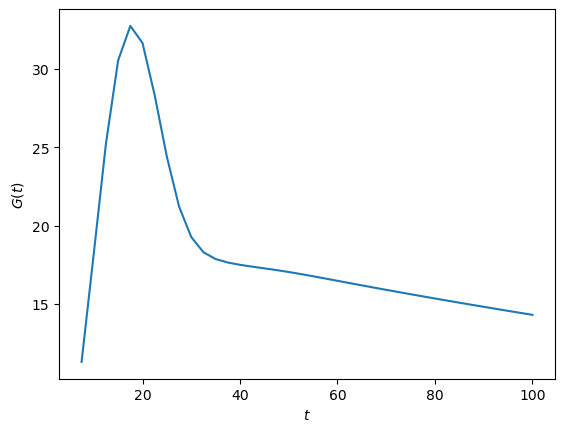

In [12]:
plt.plot(times,-np.array(gains))
plt.ylabel(r'$G(t)$')
plt.xlabel(r'$t$')

At the final time $G(t)$ was calculated the velocity profiles are

Text(0.5, 1.0, '$\\mathbf{u}_T$')

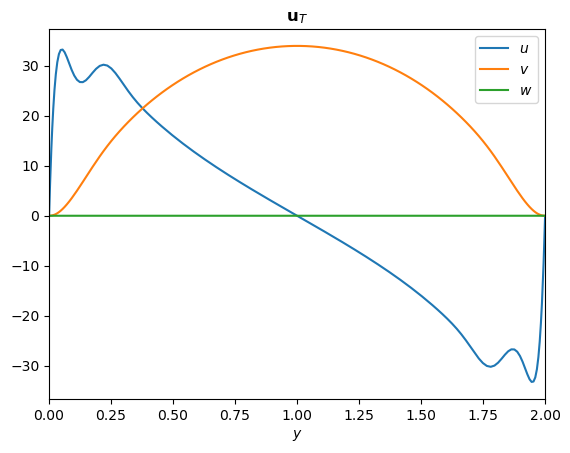

In [13]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title(r'$\mathbf{u}_T$')

(0.0, 2.0)

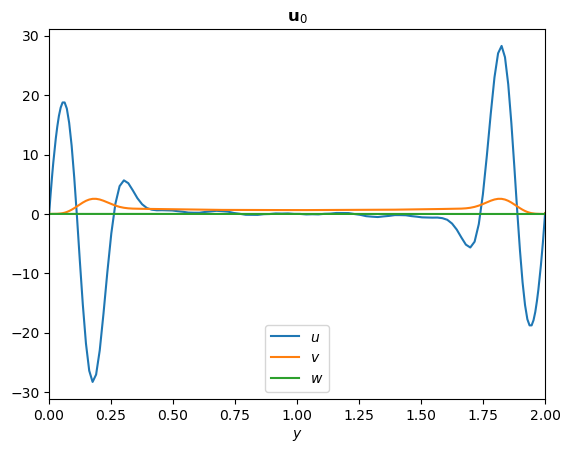

In [203]:
velocity = sol.x
u['g'] = velocity[:Ny]+1j*velocity[Ny:2*Ny]
v['g'] = velocity[2*Ny:3*Ny]+1j*velocity[3*Ny:4*Ny]
w['g'] = velocity[4*Ny:5*Ny]+1j*velocity[5*Ny:6*Ny]
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.title(r'$\mathbf{u}_0$')
plt.xlabel(r'$y$')
plt.xlim([0,2])

## Using SVD

In [149]:
M = np.sqrt(W_field['g'])
Minv = 1/M

In [173]:
def mult(velocity,Niter):
    # Modified resolvent matrix is   (MRMinv) Mq
    # Rebuild the solver
    solver = problem.build_solver(d3.RK443)
    
    # Set initial condition (must zero all non-velocity terms)
    for (i,state) in enumerate(solver.state):
        if(i>2):
            state['g'] = 0
            
    u['g'] = Minv*np.squeeze(velocity[:Ny])
    v['g'] = Minv*np.squeeze(velocity[Ny:2*Ny])
    w['g'] = Minv*np.squeeze(velocity[2*Ny:3*Ny])
    
    solver.stop_iteration = Niter
    timestep = 0.5
    
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
        
    graduDat = M*u['g']
    gradvDat = M*v['g']
    gradwDat = M*w['g']
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    return grad

In [174]:
def multHermitian(velocity,Niter):
    # Modified resolvent matrix is   (MRMinv) Mq
    # Rebuild the solver
#     solver = problem.build_solver(d3.RK443)

    solver = problem.build_solver(d3.RK443)
    
    # Set initial condition (must zero all non-velocity terms)
    for (i,state) in enumerate(solver.state):
        if(i>2):
            state['g'] = 0
            
    u['g'] = np.squeeze(velocity[:Ny])
    v['g'] = np.squeeze(velocity[Ny:2*Ny])
    w['g'] = np.squeeze(velocity[2*Ny:3*Ny])
    
    solver.stop_iteration = Niter
    timestep = 0.5
    
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
    
    # Set initial condition (must zero all non-velocity terms)
    for (i,state) in enumerate(solver.state_adj):
        if(i>2):
            state['g'] = 0
            
    solver.state_adj[0]['g'] = M*np.squeeze(velocity[:Ny])
    solver.state_adj[1]['g'] = M*np.squeeze(velocity[Ny:2*Ny])
    solver.state_adj[2]['g'] = M*np.squeeze(velocity[2*Ny:3*Ny])
        
    try:
        logger.info('Starting adjoint loop')
        while solver.iteration>0:
            solver.step_adjoint()
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()
#         print('All gone')
        
    graduDat = Minv*solver.state_adj[0]['g']
    gradvDat = Minv*solver.state_adj[1]['g']
    gradwDat = Minv*solver.state_adj[2]['g']
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    return grad

In [175]:
vec1 = np.random.rand(Ny*3) + 1j*np.random.rand(Ny*3)
vec2 = np.random.rand(Ny*3) + 1j*np.random.rand(Ny*3)

In [176]:
Avec1 = mult(vec1,100)

AHvec2 = multHermitian(vec2,100)

2023-11-16 13:12:58,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-11-16 13:12:58,200 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:12:58,301 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:12:58,302 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:12:58,302 solvers 0/1 INFO :: Final sim time: 1610.0
2023-11-16 13:12:58,303 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05158 sec
2023-11-16 13:12:58,303 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01517 sec
2023-11-16 13:12:58,304 solvers 0/1 INFO :: Run time (iter 10-end): 0.08554 sec
2023-11-16 13:12:58,304 solvers 0/1 INFO :: CPU time (iter 10-end): 2.376e-05 cpu-hr
2023-11-16 13:12:58,305 solvers 0/1 INFO :: Speed: 2.18e+06 mode-stages/cpu-sec
2023-11-16 13:12:58,351 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-11-16 13:12:58,353 __main__ 0/1 INFO :: Starting main loo

In [177]:
print(np.vdot(vec2,Avec1))
print(np.vdot(AHvec2,vec1))

print(vec2.shape)

(3.1936951410255046+5.588562991274424j)
(3.1936951410255263+5.588562991274296j)
(384,)


In [178]:
import scipy.sparse as sp
Phi = sp.linalg.LinearOperator((3*Ny,3*Ny),matvec= lambda A: mult(A,100),rmatvec=lambda A: multHermitian(A,100))

2023-11-16 13:12:59,409 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-11-16 13:12:59,411 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:12:59,513 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:12:59,514 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:12:59,514 solvers 0/1 INFO :: Final sim time: 1660.0
2023-11-16 13:12:59,515 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05041 sec
2023-11-16 13:12:59,515 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0144 sec
2023-11-16 13:12:59,516 solvers 0/1 INFO :: Run time (iter 10-end): 0.08725 sec
2023-11-16 13:12:59,517 solvers 0/1 INFO :: CPU time (iter 10-end): 2.424e-05 cpu-hr
2023-11-16 13:12:59,517 solvers 0/1 INFO :: Speed: 2.137e+06 mode-stages/cpu-sec


In [179]:
term1 = np.vdot(vec2,Phi@vec1)
term2 = np.vdot(Phi.H@vec2,vec1)

print('Error=%g' % np.abs(term1-term2))

2023-11-16 13:13:00,359 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-11-16 13:13:00,361 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:00,466 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:00,467 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:00,467 solvers 0/1 INFO :: Final sim time: 1710.0
2023-11-16 13:13:00,468 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05351 sec
2023-11-16 13:13:00,468 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01438 sec
2023-11-16 13:13:00,469 solvers 0/1 INFO :: Run time (iter 10-end): 0.09055 sec
2023-11-16 13:13:00,469 solvers 0/1 INFO :: CPU time (iter 10-end): 2.515e-05 cpu-hr
2023-11-16 13:13:00,470 solvers 0/1 INFO :: Speed: 2.059e+06 mode-stages/cpu-sec
2023-11-16 13:13:00,517 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-11-16 13:13:00,519 __main__ 0/1 INFO :: Starting main lo

In [180]:
UH,sigma,V = sp.linalg.svds(Phi)

2023-11-16 13:13:01,340 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-11-16 13:13:01,342 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:01,448 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:01,449 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:01,450 solvers 0/1 INFO :: Final sim time: 1760.0
2023-11-16 13:13:01,450 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04943 sec
2023-11-16 13:13:01,450 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01396 sec
2023-11-16 13:13:01,451 solvers 0/1 INFO :: Run time (iter 10-end): 0.09256 sec
2023-11-16 13:13:01,452 solvers 0/1 INFO :: CPU time (iter 10-end): 2.571e-05 cpu-hr
2023-11-16 13:13:01,452 solvers 0/1 INFO :: Speed: 2.015e+06 mode-stages/cpu-sec
2023-11-16 13:13:01,453 __main__ 0/1 INFO :: Starting adjoint loop
2023-11-16 13:13:01,453 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-11-16 13:13:01,702 so

2023-11-16 13:13:03,576 solvers 0/1 INFO :: CPU time (iter 10-end): 2.221e-05 cpu-hr
2023-11-16 13:13:03,577 solvers 0/1 INFO :: Speed: 2.332e+06 mode-stages/cpu-sec
2023-11-16 13:13:03,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-11-16 13:13:03,629 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:03,729 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:03,730 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:03,731 solvers 0/1 INFO :: Final sim time: 1960.0
2023-11-16 13:13:03,732 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05071 sec
2023-11-16 13:13:03,732 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.02032 sec
2023-11-16 13:13:03,733 solvers 0/1 INFO :: Run time (iter 10-end): 0.07996 sec
2023-11-16 13:13:03,734 solvers 0/1 INFO :: CPU time (iter 10-end): 2.221e-05 cpu-hr
2023-11-16 13:13:03,735 solvers 0/1 INFO :: Speed: 2.332e+06 mode-stages/cpu-sec
2023-11-16 13:13:03,736 __m

2023-11-16 13:13:05,755 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0136 sec
2023-11-16 13:13:05,756 solvers 0/1 INFO :: Run time (iter 10-end): 0.07234 sec
2023-11-16 13:13:05,756 solvers 0/1 INFO :: CPU time (iter 10-end): 2.009e-05 cpu-hr
2023-11-16 13:13:05,757 solvers 0/1 INFO :: Speed: 2.578e+06 mode-stages/cpu-sec
2023-11-16 13:13:05,809 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-11-16 13:13:05,811 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:05,896 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:05,897 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:05,897 solvers 0/1 INFO :: Final sim time: 2160.0
2023-11-16 13:13:05,898 solvers 0/1 INFO :: Setup time (init - iter 0): 0.05195 sec
2023-11-16 13:13:05,899 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0136 sec
2023-11-16 13:13:05,900 solvers 0/1 INFO :: Run time (iter 10-end): 0.07165 sec
2023-11-16 13:13:05,901 solvers 0/

2023-11-16 13:13:07,899 solvers 0/1 INFO :: Final sim time: 2310.0
2023-11-16 13:13:07,900 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04483 sec
2023-11-16 13:13:07,901 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01258 sec
2023-11-16 13:13:07,902 solvers 0/1 INFO :: Run time (iter 10-end): 0.07514 sec
2023-11-16 13:13:07,902 solvers 0/1 INFO :: CPU time (iter 10-end): 2.087e-05 cpu-hr
2023-11-16 13:13:07,903 solvers 0/1 INFO :: Speed: 2.482e+06 mode-stages/cpu-sec
2023-11-16 13:13:07,951 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-11-16 13:13:07,953 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:08,037 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:08,038 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:08,039 solvers 0/1 INFO :: Final sim time: 2360.0
2023-11-16 13:13:08,040 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04789 sec
2023-11-16 13:13:08,040 solvers 0/1 INFO :

2023-11-16 13:13:10,162 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:10,162 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:10,163 solvers 0/1 INFO :: Final sim time: 2510.0
2023-11-16 13:13:10,164 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04783 sec
2023-11-16 13:13:10,164 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01508 sec
2023-11-16 13:13:10,165 solvers 0/1 INFO :: Run time (iter 10-end): 0.08053 sec
2023-11-16 13:13:10,166 solvers 0/1 INFO :: CPU time (iter 10-end): 2.237e-05 cpu-hr
2023-11-16 13:13:10,167 solvers 0/1 INFO :: Speed: 2.316e+06 mode-stages/cpu-sec
2023-11-16 13:13:10,218 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-11-16 13:13:10,221 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:10,310 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:10,311 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:10,311 solvers 0/1 INFO :: Final sim time: 

2023-11-16 13:13:12,559 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:12,649 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:12,650 solvers 0/1 INFO :: Final iteration: 100
2023-11-16 13:13:12,651 solvers 0/1 INFO :: Final sim time: 2710.0
2023-11-16 13:13:12,651 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04616 sec
2023-11-16 13:13:12,652 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01351 sec
2023-11-16 13:13:12,653 solvers 0/1 INFO :: Run time (iter 10-end): 0.07685 sec
2023-11-16 13:13:12,654 solvers 0/1 INFO :: CPU time (iter 10-end): 2.135e-05 cpu-hr
2023-11-16 13:13:12,654 solvers 0/1 INFO :: Speed: 2.426e+06 mode-stages/cpu-sec
2023-11-16 13:13:12,709 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2023-11-16 13:13:12,711 __main__ 0/1 INFO :: Starting main loop
2023-11-16 13:13:12,809 solvers 0/1 INFO :: Stop iteration reached.
2023-11-16 13:13:12,810 solvers 0/1 INFO :: Final iteration: 

2023-11-16 13:13:15,237 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0567 sec
2023-11-16 13:13:15,238 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.


In [182]:
print(sigma[::-1])

[4.12718708 0.66968251 0.3923011  0.36358765 0.34646445 0.29492315]


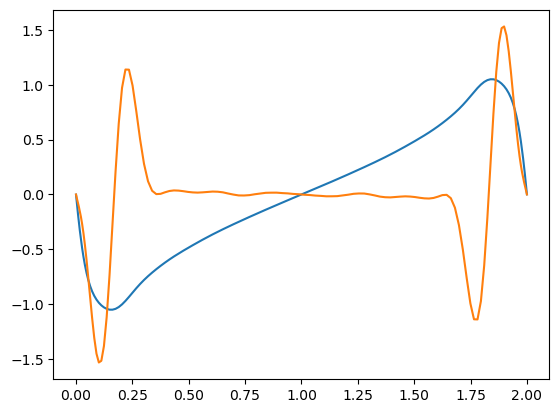

In [201]:
plt.plot(y,Minv*UH[:Ny,-1].real)
plt.plot(y,Minv*V[-1,:Ny].real)

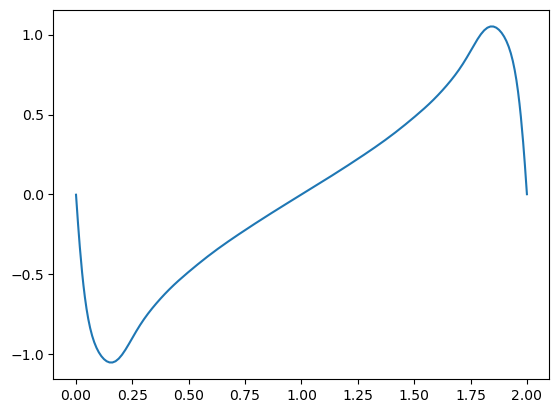

In [200]:
plt.plot(y,Minv*UH[:Ny,-1].real)

## Taylor test
Because $\mathcal{J}(\mathbf{u}_0+\epsilon \mathbf{u}')=\mathcal{J}(\mathbf{u}_0)+\epsilon \mathbf{\nabla J} \cdot \mathbf{u}' + \mathcal{O}(\epsilon^2)$. We can check that $|\mathcal{J}(\mathbf{u}_0+\epsilon \mathbf{u}')-\mathcal{J}(\mathbf{u}_0)-\epsilon \mathbf{\nabla J} \cdot \mathbf{u}'|$ decays at a second order rate.

In [15]:
forcing0 = np.random.rand(Ny*2*3)
forcingp = np.random.rand(Ny*2*3)
cost0,grad0 = directAdjointLoop(forcing0,100)

eps = 0.001
costs = []
size = []
for i in range(10):
    costp,gradp = directAdjointLoop(forcing0+eps*forcingp,100)
    costs.append(costp)
    size.append(eps)
    eps /= 2

2023-05-10 09:46:42,408 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:46:42,411 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:42,500 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:46:42,500 solvers 0/1 INFO :: Final iteration: 100
2023-05-10 09:46:42,501 solvers 0/1 INFO :: Final sim time: 50.0
2023-05-10 09:46:42,501 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04134 sec
2023-05-10 09:46:42,502 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01418 sec
2023-05-10 09:46:42,503 solvers 0/1 INFO :: Run time (iter 10-end): 0.07477 sec
2023-05-10 09:46:42,503 solvers 0/1 INFO :: CPU time (iter 10-end): 2.077e-05 cpu-hr
2023-05-10 09:46:42,504 solvers 0/1 INFO :: Speed: 2.494e+06 mode-stages/cpu-sec
2023-05-10 09:46:42,504 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:42,505 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:42,921 solv

2023-05-10 09:46:45,794 solvers 0/1 INFO :: Run time (iter 10-end): 0.07154 sec
2023-05-10 09:46:45,794 solvers 0/1 INFO :: CPU time (iter 10-end): 1.987e-05 cpu-hr
2023-05-10 09:46:45,795 solvers 0/1 INFO :: Speed: 2.607e+06 mode-stages/cpu-sec
2023-05-10 09:46:45,795 __main__ 0/1 INFO :: Starting adjoint loop
2023-05-10 09:46:45,796 solvers 0/1 INFO :: Warning: Only works if F==0 and linear direct equation.
2023-05-10 09:46:46,203 solvers 0/1 INFO :: Final iteration: 0
2023-05-10 09:46:46,204 solvers 0/1 INFO :: Final sim time: 0.0
2023-05-10 09:46:46,204 solvers 0/1 INFO :: Setup time (init - iter 0): 0.04192 sec
2023-05-10 09:46:46,205 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.
2023-05-10 09:46:46,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-05-10 09:46:46,247 __main__ 0/1 INFO :: Starting main loop
2023-05-10 09:46:46,335 solvers 0/1 INFO :: Stop iteration reached.
2023-05-10 09:4

In [16]:
first = np.abs(np.array(costs)-cost0)
second = np.abs(np.array(costs)-cost0 - np.array(size)*np.vdot(grad0,forcingp))

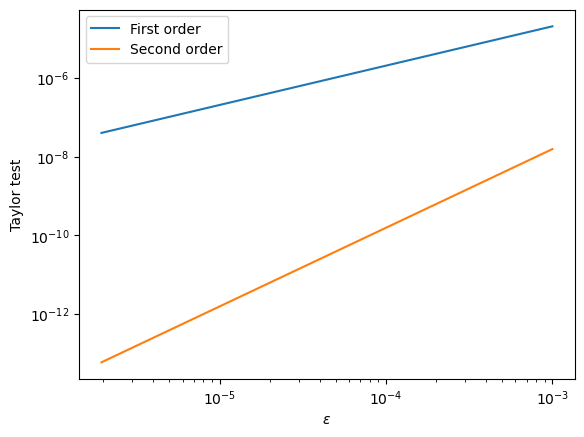

In [17]:
plt.loglog(size,first,label=r'First order')
plt.loglog(size,second,label=r'Second order')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'Taylor test')
plt.legend()

In [18]:
from scipy.stats import linregress
print('######## Taylor Test Results ########')
print('First order  : ',linregress(np.log(size), np.log(first)).slope)
print('Second order : ',linregress(np.log(size), np.log(second)).slope)
print('#####################################')

######## Taylor Test Results ########
First order  :  0.9999070846722805
Second order :  2.0002074030256964
#####################################
